In [ ]:
import cv2
import dlib
import numpy as np
import os
import pandas as pd # Import pandas for CSV handling

# Load detector and predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(
    "models/shape_predictor_68_face_landmarks.dat/shape_predictor_68_face_landmarks.dat"
)

# Define the root directories for input and output
root_input_dir = "archive_3"
root_output_dir = "processed_faces_newFinal8_1"

# Define the scaling factor for upscaling images
scale_factor = 12

# Create the root output directory if it doesn't exist
os.makedirs(root_output_dir, exist_ok=True)

# List of emotion folders
emotion_folders = ["anger", "contempt", "disgust", "happy", "sadness", "fear", "surprise"]

# List to store all landmark and fitted shape data for CSV export
all_facial_features_data = [] # Renamed for clarity to include more than just raw landmarks

print("Starting facial landmark detection, shape drawing, and feature extraction...")
print("Output images will be split into '_with_photo', '_without_photo', and '_shapes_drawn' folders.")
print("A comprehensive CSV file with landmark coordinates AND fitted shape parameters will be generated.")

# --- Helper Function for Drawing Shapes (from previous correction) ---
def draw_facial_shapes(image, landmarks):
    """
    Draws different geometric shapes on a given image based on facial landmarks.
    Args:
        image (numpy.ndarray): The image on which to draw.
        landmarks (dlib.full_object_detection): Dlib's landmark object.
    Returns:
        numpy.ndarray: The image with shapes drawn.
    """
    drawn_image = image.copy()

    # Define colors for different shapes (BGR format)
    color_eyebrows = (0, 255, 0)   # Green
    color_eyes = (255, 0, 0)       # Blue
    color_nose_bridge = (0, 255, 255) # Yellow
    color_nose_tip = (255, 255, 0) # Cyan
    color_lips = (0, 165, 255)     # Orange
    color_cheeks = (128, 0, 128)   # Purple
    thickness = 2 # Line thickness

    # --- Eyebrows (Approximated by polylines) ---
    # Left Eyebrow: 17-21
    for i in range(17, 21):
        pt1 = (landmarks.part(i).x, landmarks.part(i).y)
        pt2 = (landmarks.part(i + 1).x, landmarks.part(i + 1).y)
        cv2.line(drawn_image, pt1, pt2, color_eyebrows, thickness)

    # Right Eyebrow: 22-26
    for i in range(22, 26):
        pt1 = (landmarks.part(i).x, landmarks.part(i).y)
        pt2 = (landmarks.part(i + 1).x, landmarks.part(i + 1).y)
        cv2.line(drawn_image, pt1, pt2, color_eyebrows, thickness)

    # --- Eyes (Ellipses) ---
    # Left Eye: 36-41
    left_eye_points = np.array([(landmarks.part(n).x, landmarks.part(n).y) for n in range(36, 42)])
    if len(left_eye_points) >= 5: # cv2.fitEllipse requires at least 5 points
        try: # Add try-except for robustness against poor point configurations
            (center_le, axes_le, angle_le) = cv2.fitEllipse(left_eye_points)
            if axes_le[0] > 0 and axes_le[1] > 0: # Ensure axes are valid
                cv2.ellipse(drawn_image, (int(center_le[0]), int(center_le[1])),
                            (int(axes_le[0] / 2), int(axes_le[1] / 2)),
                            angle_le, 0, 360, color_eyes, thickness)
        except cv2.error:
            # print(f"Warning: Could not fit ellipse for left eye. Skipping drawing.")
            pass # Suppress drawing error, fitting will use NaN

    # Right Eye: 42-47
    right_eye_points = np.array([(landmarks.part(n).x, landmarks.part(n).y) for n in range(42, 48)])
    if len(right_eye_points) >= 5:
        try:
            (center_re, axes_re, angle_re) = cv2.fitEllipse(right_eye_points)
            if axes_re[0] > 0 and axes_re[1] > 0:
                cv2.ellipse(drawn_image, (int(center_re[0]), int(center_re[1])),
                            (int(axes_re[0] / 2), int(axes_re[1] / 2)),
                            angle_re, 0, 360, color_eyes, thickness)
        except cv2.error:
            # print(f"Warning: Could not fit ellipse for right eye. Skipping drawing.")
            pass # Suppress drawing error, fitting will use NaN


    # --- Nose ---
    # Nose Bridge (Trapezium): Using landmarks 27, 28, 29, 30
    nose_bridge_pts = np.array([
        (landmarks.part(27).x, landmarks.part(27).y),
        (landmarks.part(28).x, landmarks.part(28).y),
        (landmarks.part(29).x, landmarks.part(29).y),
        (landmarks.part(30).x, landmarks.part(30).y)
    ], np.int32).reshape((-1, 1, 2))
    cv2.polylines(drawn_image, [nose_bridge_pts], True, color_nose_bridge, thickness)

    # Nose Tip (Triangle): Using landmarks 30, 31, 35
    nose_tip_pts = np.array([
        (landmarks.part(30).x, landmarks.part(30).y),
        (landmarks.part(31).x, landmarks.part(31).y),
        (landmarks.part(35).x, landmarks.part(35).y)
    ], np.int32).reshape((-1, 1, 2))
    cv2.polylines(drawn_image, [nose_tip_pts], True, color_nose_tip, thickness)

    # --- Lips (Outer Lip Ellipse) ---
    # Outer Lip: 48-59
    outer_lip_points = np.array([(landmarks.part(n).x, landmarks.part(n).y) for n in range(48, 60)])
    if len(outer_lip_points) >= 5:
        try:
            (center_ol, axes_ol, angle_ol) = cv2.fitEllipse(outer_lip_points)
            if axes_ol[0] > 0 and axes_ol[1] > 0:
                cv2.ellipse(drawn_image, (int(center_ol[0]), int(center_ol[1])),
                            (int(axes_ol[0] / 2), int(axes_ol[1] / 2)),
                            angle_ol, 0, 360, color_lips, thickness)
        except cv2.error:
            # print(f"Warning: Could not fit ellipse for outer lip. Skipping drawing.")
            pass # Suppress drawing error, fitting will use NaN

    # --- Cheeks (Approximated by Broader Triangles) ---
    # Left Cheek: Using outer eye corner (36), outer jawline (2), left mouth corner (48)
    left_cheek_pts = np.array([
        (landmarks.part(36).x, landmarks.part(36).y), # Left outer eye corner
        (landmarks.part(2).x, landmarks.part(2).y),   # Left jawline (near chin)
        (landmarks.part(48).x, landmarks.part(48).y)  # Left mouth corner
    ], np.int32).reshape((-1, 1, 2))
    cv2.polylines(drawn_image, [left_cheek_pts], True, color_cheeks, thickness)

    # Right Cheek: Using outer eye corner (45), outer jawline (14), right mouth corner (54)
    right_cheek_pts = np.array([
        (landmarks.part(45).x, landmarks.part(45).y), # Right outer eye corner
        (landmarks.part(14).x, landmarks.part(14).y), # Right jawline (near chin)
        (landmarks.part(54).x, landmarks.part(54).y)  # Right mouth corner
    ], np.int32).reshape((-1, 1, 2))
    cv2.polylines(drawn_image, [right_cheek_pts], True, color_cheeks, thickness)

    return drawn_image

# --- Helper Functions for Curve Fitting ---

def fit_parabola_params(points):
    """
    Fits a 2nd-degree polynomial (parabola) to a set of (x, y) points.
    Returns (a, b, c) for y = ax^2 + bx + c.
    Returns (NaN, NaN, NaN) if fitting fails.
    """
    if len(points) < 3: # Need at least 3 points to fit a parabola
        return np.nan, np.nan, np.nan
    x_coords = np.array([p[0] for p in points])
    y_coords = np.array([p[1] for p in points])
    try:
        # polyfit can sometimes raise warnings for ill-conditioned matrices
        # Suppress warnings if you are sure about the input data
        with np.errstate(all='raise'):
            coefficients = np.polyfit(x_coords, y_coords, 2)
            return tuple(coefficients) # (a, b, c)
    except Exception as e: # Catch numpy polynomial fitting errors
        # print(f"Warning: Parabola fitting failed: {e}")
        return np.nan, np.nan, np.nan

def fit_ellipse_params(points):
    """
    Fits an ellipse to a set of (x, y) points using cv2.fitEllipse.
    Returns (center_x, center_y, major_axis, minor_axis, angle)
    Returns (NaN, NaN, NaN, NaN, NaN) if fitting fails or points are insufficient.
    """
    if len(points) < 5: # cv2.fitEllipse requires at least 5 points
        return np.nan, np.nan, np.nan, np.nan, np.nan
    points_np = np.array(points, dtype=np.int32)
    try:
        (center, axes, angle) = cv2.fitEllipse(points_np)
        # Ensure axes are positive; sometimes very small or negative can be returned
        if axes[0] <= 0 or axes[1] <= 0:
            return np.nan, np.nan, np.nan, np.nan, np.nan

        # axes are (major_axis_length, minor_axis_length) or vice-versa.
        # It's diameter, so convert to radius if needed for other applications.
        # For now, we'll store diameter values as returned.
        return center[0], center[1], axes[0], axes[1], angle
    except cv2.error as e:
        # print(f"Warning: Ellipse fitting failed: {e}")
        return np.nan, np.nan, np.nan, np.nan, np.nan
    except Exception as e: # Catch any other unexpected errors
        # print(f"Warning: Ellipse fitting failed unexpectedly: {e}")
        return np.nan, np.nan, np.nan, np.nan, np.nan


# --- Main Processing Loop ---
for emotion in emotion_folders:
    input_emotion_path = os.path.join(root_input_dir, emotion)

    # Define the new output subfolders for each emotion
    output_with_photo_path = os.path.join(root_output_dir, emotion, f"{emotion}_with_photo")
    output_without_photo_path = os.path.join(root_output_dir, emotion, f"{emotion}_without_photo")
    output_shapes_drawn_path = os.path.join(root_output_dir, emotion, f"{emotion}_shapes_drawn")

    # Create these new output subdirectories if they don't exist
    os.makedirs(output_with_photo_path, exist_ok=True)
    os.makedirs(output_without_photo_path, exist_ok=True)
    os.makedirs(output_shapes_drawn_path, exist_ok=True)

    print(f"\nProcessing emotion: {emotion}...")

    for filename in os.listdir(input_emotion_path):
        if filename.lower().endswith((".png", ".jpg", ".jpeg", ".bmp", ".tiff")):
            image_path = os.path.join(input_emotion_path, filename)
            image = cv2.imread(image_path)

            if image is None:
                print(f"Warning: Could not read image {image_path}. Skipping.")
                continue

            print(f"  Processing file: {filename}")

            upscaled_image = cv2.resize(image, (0, 0), fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_CUBIC)
            gray = cv2.cvtColor(upscaled_image, cv2.COLOR_BGR2GRAY)

            faces = detector(gray)

            if len(faces) > 0:
                face = faces[0]
                landmarks = predictor(gray, face)

                # --- Initialize row for CSV data ---
                current_image_features = {'emotion': emotion, 'filename': filename}

                # --- Collect raw landmark data for CSV ---
                for n in range(68):
                    x = landmarks.part(n).x
                    y = landmarks.part(n).y
                    current_image_features[f'landmark_{n}_x'] = x
                    current_image_features[f'landmark_{n}_y'] = y

                # --- Apply Curve Fitting Algorithms and Store Parameters ---

                # Left Eyebrow (Parabola: y = ax^2 + bx + c)
                leb_points = [(landmarks.part(n).x, landmarks.part(n).y) for n in range(17, 22)]
                a_leb, b_leb, c_leb = fit_parabola_params(leb_points)
                current_image_features['leb_parabola_a'] = a_leb
                current_image_features['leb_parabola_b'] = b_leb
                current_image_features['leb_parabola_c'] = c_leb

                # Right Eyebrow (Parabola: y = ax^2 + bx + c)
                reb_points = [(landmarks.part(n).x, landmarks.part(n).y) for n in range(22, 27)]
                a_reb, b_reb, c_reb = fit_parabola_params(reb_points)
                current_image_features['reb_parabola_a'] = a_reb
                current_image_features['reb_parabola_b'] = b_reb
                current_image_features['reb_parabola_c'] = c_reb

                # Left Eye (Ellipse: center_x, center_y, major_axis, minor_axis, angle)
                le_points = [(landmarks.part(n).x, landmarks.part(n).y) for n in range(36, 42)]
                cx_le, cy_le, maj_le, min_le, ang_le = fit_ellipse_params(le_points)
                current_image_features['le_ellipse_center_x'] = cx_le
                current_image_features['le_ellipse_center_y'] = cy_le
                current_image_features['le_ellipse_major_axis'] = maj_le
                current_image_features['le_ellipse_minor_axis'] = min_le
                current_image_features['le_ellipse_angle'] = ang_le

                # Right Eye (Ellipse)
                re_points = [(landmarks.part(n).x, landmarks.part(n).y) for n in range(42, 48)]
                cx_re, cy_re, maj_re, min_re, ang_re = fit_ellipse_params(re_points)
                current_image_features['re_ellipse_center_x'] = cx_re
                current_image_features['re_ellipse_center_y'] = cy_re
                current_image_features['re_ellipse_major_axis'] = maj_re
                current_image_features['re_ellipse_minor_axis'] = min_re
                current_image_features['re_ellipse_angle'] = ang_re

                # Outer Lip (Ellipse)
                ol_points = [(landmarks.part(n).x, landmarks.part(n).y) for n in range(48, 60)]
                cx_ol, cy_ol, maj_ol, min_ol, ang_ol = fit_ellipse_params(ol_points)
                current_image_features['ol_ellipse_center_x'] = cx_ol
                current_image_features['ol_ellipse_center_y'] = cy_ol
                current_image_features['ol_ellipse_major_axis'] = maj_ol
                current_image_features['ol_ellipse_minor_axis'] = min_ol
                current_image_features['ol_ellipse_angle'] = ang_ol

                # Nose Bridge (Trapezium - extract vertices)
                current_image_features['nose_bridge_v1_x'] = landmarks.part(27).x
                current_image_features['nose_bridge_v1_y'] = landmarks.part(27).y
                current_image_features['nose_bridge_v2_x'] = landmarks.part(28).x
                current_image_features['nose_bridge_v2_y'] = landmarks.part(28).y
                current_image_features['nose_bridge_v3_x'] = landmarks.part(29).x
                current_image_features['nose_bridge_v3_y'] = landmarks.part(29).y
                current_image_features['nose_bridge_v4_x'] = landmarks.part(30).x
                current_image_features['nose_bridge_v4_y'] = landmarks.part(30).y

                # Nose Tip (Triangle - extract vertices)
                current_image_features['nose_tip_v1_x'] = landmarks.part(30).x
                current_image_features['nose_tip_v1_y'] = landmarks.part(30).y
                current_image_features['nose_tip_v2_x'] = landmarks.part(31).x
                current_image_features['nose_tip_v2_y'] = landmarks.part(31).y
                current_image_features['nose_tip_v3_x'] = landmarks.part(35).x
                current_image_features['nose_tip_v3_y'] = landmarks.part(35).y

                # Left Cheek (Triangle - extract vertices)
                current_image_features['left_cheek_v1_x'] = landmarks.part(36).x
                current_image_features['left_cheek_v1_y'] = landmarks.part(36).y
                current_image_features['left_cheek_v2_x'] = landmarks.part(2).x
                current_image_features['left_cheek_v2_y'] = landmarks.part(2).y
                current_image_features['left_cheek_v3_x'] = landmarks.part(48).x
                current_image_features['left_cheek_v3_y'] = landmarks.part(48).y

                # Right Cheek (Triangle - extract vertices)
                current_image_features['right_cheek_v1_x'] = landmarks.part(45).x
                current_image_features['right_cheek_v1_y'] = landmarks.part(45).y
                current_image_features['right_cheek_v2_x'] = landmarks.part(14).x
                current_image_features['right_cheek_v2_y'] = landmarks.part(14).y
                current_image_features['right_cheek_v3_x'] = landmarks.part(54).x
                current_image_features['right_cheek_v3_y'] = landmarks.part(54).y
                
                
                # --- Advanced Geometric Features (Distances, Ratios, Angles) ---

                def euclidean(pt1, pt2):
                    return np.linalg.norm(np.array(pt1) - np.array(pt2))

                def calculate_angle(pt1, pt2, pt3):
                    a = np.array(pt1)
                    b = np.array(pt2)
                    c = np.array(pt3)
                    ba = a - b
                    bc = c - b
                    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
                    return np.degrees(np.arccos(np.clip(cosine_angle, -1.0, 1.0)))

                # Helper: Get (x, y) for a landmark
                def get_pt(idx): return (landmarks.part(idx).x, landmarks.part(idx).y)

                # Distance between eyes
                eye_left = get_pt(36)
                eye_right = get_pt(45)
                current_image_features['eye_distance'] = euclidean(eye_left, eye_right)

                # EAR for Left Eye (36-41)
                eye_l = [get_pt(i) for i in range(36, 42)]
                A = euclidean(eye_l[1], eye_l[5])
                B = euclidean(eye_l[2], eye_l[4])
                C = euclidean(eye_l[0], eye_l[3])
                current_image_features['left_eye_ear'] = (A + B) / (2.0 * C)

                # EAR for Right Eye (42-47)
                eye_r = [get_pt(i) for i in range(42, 48)]
                A = euclidean(eye_r[1], eye_r[5])
                B = euclidean(eye_r[2], eye_r[4])
                C = euclidean(eye_r[0], eye_r[3])
                current_image_features['right_eye_ear'] = (A + B) / (2.0 * C)

                # MAR (Mouth Aspect Ratio) using outer mouth points 60–67
                mouth = [get_pt(i) for i in range(60, 68)]
                A = euclidean(mouth[2], mouth[10 % 8])
                B = euclidean(mouth[3], mouth[9 % 8])
                C = euclidean(mouth[4], mouth[8 % 8])
                horizontal = euclidean(mouth[0], mouth[6])
                current_image_features['mouth_mar'] = (A + B + C) / (3.0 * horizontal)

                # Nose Angle: points 27 (nose top), 30 (tip), 8 (chin)
                current_image_features['nose_angle'] = calculate_angle(get_pt(27), get_pt(30), get_pt(8))

                # Eyebrow Angle (slope between start and end of left eyebrow: 17–21)
                current_image_features['left_eyebrow_angle'] = calculate_angle(get_pt(19), get_pt(17), get_pt(21))


                # Add the collected and fitted data row to the main list
                all_facial_features_data.append(current_image_features)

                # --- Prepare images for all output types (visualizations) ---
                drawn_image_with_photo = upscaled_image.copy()
                drawn_image_without_photo = np.zeros(upscaled_image.shape, dtype=np.uint8)
                drawn_image_shapes_only = np.zeros(upscaled_image.shape, dtype=np.uint8)

                # Get position of landmark 31 for quadrant lines (on _with_photo image)
                nose_x = landmarks.part(30).x
                nose_y = landmarks.part(30).y
                img_h, img_w = drawn_image_with_photo.shape[:2]
                cv2.line(drawn_image_with_photo, (nose_x, 0), (nose_x, img_h), (0, 255, 0), 1)
                cv2.line(drawn_image_with_photo, (0, nose_y), (img_w, nose_y), (0, 255, 0), 1)

                drawn_index = 1
                seen = set()

                for n in range(68):
                    x = landmarks.part(n).x
                    y = landmarks.part(n).y

                    if (x, y) in seen:
                        continue
                    seen.add((x, y))

                    circle_radius = 2
                    fill_type = -1

                    # Offset for label (re-using your existing logic)
                    offset_x, offset_y = -6, 10
                    if n in [37, 38, 39, 43, 44, 45]: # Upper eye points
                        offset_y = -10
                    elif n == 49: # Left mouth corner
                        offset_x = -20
                        offset_y = 6
                    elif n == 50: # Top lip center
                        offset_x = 0
                        offset_y = -8
                    elif n == 65: # Chin left
                        offset_x = -14
                        offset_y = 10
                    elif 48 <= n <= 54: # Upper lip
                        offset_y = -8
                    elif 55 <= n <= 59: # Lower lip center to right
                        offset_y = 10
                    elif 60 <= n <= 64: # Inner mouth top
                        offset_y = -8
                    elif 65 <= n <= 67: # Chin right
                        offset_y = 10

                    # Draw on the image WITH photo (original background)
                    text_color_with_photo = (0, 0, 0) # Black text
                    cv2.circle(drawn_image_with_photo, (x, y), circle_radius, (0, 0, 255), fill_type) # Red circles
                    cv2.putText(drawn_image_with_photo, str(drawn_index), (x + offset_x, y + offset_y),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.35, text_color_with_photo, 1, cv2.LINE_AA)

                    # Draw on the image WITHOUT photo (black background)
                    text_color_without_photo = (255, 255, 255) # White text/circles
                    cv2.circle(drawn_image_without_photo, (x, y), circle_radius, text_color_without_photo, fill_type)
                    cv2.putText(drawn_image_without_photo, str(drawn_index), (x + offset_x, y + offset_y),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.35, text_color_without_photo, 1, cv2.LINE_AA)

                    drawn_index += 1

                # --- Draw the specific shapes on the dedicated 'shapes_only' image ---
                drawn_image_shapes_only = draw_facial_shapes(drawn_image_shapes_only, landmarks)

                # Save the processed images to their respective folders
                output_image_path_with_photo = os.path.join(output_with_photo_path, filename)
                cv2.imwrite(output_image_path_with_photo, drawn_image_with_photo)

                output_image_path_without_photo = os.path.join(output_without_photo_path, filename)
                cv2.imwrite(output_image_path_without_photo, drawn_image_without_photo)

                output_image_path_shapes_drawn = os.path.join(output_shapes_drawn_path, filename)
                cv2.imwrite(output_image_path_shapes_drawn, drawn_image_shapes_only)

            else:
                print(f"  No face detected in {filename} from {emotion} folder.")

print("\nAll emotion folders and photos processed successfully!")

# --- Save all collected facial feature data to a single CSV file ---
if all_facial_features_data:
    df = pd.DataFrame(all_facial_features_data)
    # Ensure all columns are present, even if some fits failed for certain images (filled with NaN)
    # CORRECTED LINE: Removed 'axis=1'
    df = df.reindex(columns=sorted(df.columns)) # Optional: sort columns alphabetically
    csv_output_path = os.path.join(root_output_dir, "facial_features_and_landmarks_data.csv")
    df.to_csv(csv_output_path, index=False)
    print(f"All facial landmark coordinates and fitted shape parameters saved to: {csv_output_path}")
else:
    print("No facial feature data was collected (no faces detected or no images processed).")

Starting facial landmark detection, shape drawing, and feature extraction...
Output images will be split into '_with_photo', '_without_photo', and '_shapes_drawn' folders.
A comprehensive CSV file with landmark coordinates AND fitted shape parameters will be generated.

Processing emotion: anger...
  Processing file: S010_004_00000017.png
  Processing file: S010_004_00000018.png
  Processing file: S010_004_00000019.png
  Processing file: S011_004_00000019.png
  Processing file: S011_004_00000020.png
  Processing file: S011_004_00000021.png
  Processing file: S014_003_00000028.png
  Processing file: S014_003_00000029.png
  Processing file: S014_003_00000030.png
  Processing file: S022_005_00000030.png
  Processing file: S022_005_00000031.png
  Processing file: S022_005_00000032.png
  Processing file: S026_003_00000013.png
  Processing file: S026_003_00000014.png
  Processing file: S026_003_00000015.png
  Processing file: S028_001_00000022.png
  Processing file: S028_001_00000023.png
  P

In [2]:
import pandas as pd
import os
from sklearn.preprocessing import LabelEncoder

# Step 1: Define paths
input_csv_path = "processed_faces_newFinal8_1/facial_features_and_landmarks_data.csv"
output_folder = "processed_faces_newFinal8_1"
output_csv_path = os.path.join(output_folder, "facial_features_and_landmarks_data_cleaned.csv")

# Step 2: Create the new output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Step 3: Load the original dataset
df = pd.read_csv(input_csv_path)
print(f"Original dataset shape: {df.shape}")

# Step 4: Drop non-feature columns
if 'filename' in df.columns:
    df = df.drop(columns=["filename"])

# Step 5: Encode 'emotion' column (target variable)
if 'emotion' in df.columns:
    le = LabelEncoder()
    df['emotion'] = le.fit_transform(df['emotion'])  # e.g., anger → 0, happy → 1, etc.
    print(f"Encoded emotion labels: {dict(zip(le.classes_, le.transform(le.classes_)))}")

# Step 6: Drop rows with any missing values (NaNs from failed fittings)
df_cleaned = df.dropna()
print(f"Cleaned dataset shape after dropping NaNs: {df_cleaned.shape}")

# Step 7: Save the cleaned dataset
df_cleaned.to_csv(output_csv_path, index=False)
print(f"Cleaned data saved to: {output_csv_path}")


Original dataset shape: (980, 191)
Encoded emotion labels: {'anger': 0, 'contempt': 1, 'disgust': 2, 'fear': 3, 'happy': 4, 'sadness': 5, 'surprise': 6}
Cleaned dataset shape after dropping NaNs: (980, 190)
Cleaned data saved to: processed_faces_newFinal8_1\facial_features_and_landmarks_data_cleaned.csv


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import os

# Step 1: Load the cleaned dataset
input_csv_path = "processed_faces_newFinal8_1/facial_features_and_landmarks_data_cleaned.csv"
df = pd.read_csv(input_csv_path)
print(f"Dataset shape: {df.shape}")

# Step 2: Split features (X) and labels (y)
X = df.drop(columns=["emotion"])
y = df["emotion"]

# Step 3: Train-test split (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Step 4: Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 5: Train Logistic Regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)

# Step 6: Predict on test set
y_pred = model.predict(X_test_scaled)

# Step 7: Accuracy Scores
train_accuracy = model.score(X_train_scaled, y_train)
test_accuracy = model.score(X_test_scaled, y_test)

print(f"\nTraining Accuracy: {train_accuracy * 100:.2f}%")
print(f"Testing Accuracy:  {test_accuracy * 100:.2f}%")

# Step 8: Evaluation Metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Dataset shape: (980, 190)

Training Accuracy: 100.00%
Testing Accuracy:  100.00%

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        27
           1       1.00      1.00      1.00        11
           2       1.00      1.00      1.00        35
           3       1.00      1.00      1.00        15
           4       1.00      1.00      1.00        41
           5       1.00      1.00      1.00        17
           6       1.00      1.00      1.00        50

    accuracy                           1.00       196
   macro avg       1.00      1.00      1.00       196
weighted avg       1.00      1.00      1.00       196

Confusion Matrix:
[[27  0  0  0  0  0  0]
 [ 0 11  0  0  0  0  0]
 [ 0  0 35  0  0  0  0]
 [ 0  0  0 15  0  0  0]
 [ 0  0  0  0 41  0  0]
 [ 0  0  0  0  0 17  0]
 [ 0  0  0  0  0  0 50]]


In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load cleaned data
df = pd.read_csv("processed_faces_newFinal8_1/facial_features_and_landmarks_data_cleaned.csv")

# Encode target
le = LabelEncoder()
df["emotion_encoded"] = le.fit_transform(df["emotion"])

# Identify columns to drop (safely)
drop_cols = ["emotion", "filename", "emotion_encoded"]
drop_cols = [col for col in drop_cols if col in df.columns]

# Features and target
X = df.drop(columns=drop_cols)
y = df["emotion_encoded"]

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# KNN Classifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Predictions
y_pred_train = knn.predict(X_train)
y_pred_test = knn.predict(X_test)

# Accuracy scores
train_acc = accuracy_score(y_train, y_pred_train)
test_acc = accuracy_score(y_test, y_pred_test)

# Results
print(f"Dataset shape: {df.shape}")
print(f"\nTraining Accuracy: {train_acc:.2%}")
print(f"Testing Accuracy:  {test_acc:.2%}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_test))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_test))


Dataset shape: (980, 191)

Training Accuracy: 91.71%
Testing Accuracy:  72.96%

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.59      0.54        27
           1       0.50      0.64      0.56        11
           2       0.65      0.63      0.64        35
           3       0.75      0.60      0.67        15
           4       0.86      0.90      0.88        41
           5       0.40      0.35      0.38        17
           6       1.00      0.92      0.96        50

    accuracy                           0.73       196
   macro avg       0.67      0.66      0.66       196
weighted avg       0.74      0.73      0.73       196

Confusion Matrix:
[[16  2  5  0  0  4  0]
 [ 1  7  0  0  0  3  0]
 [ 7  1 22  0  5  0  0]
 [ 2  2  0  9  1  1  0]
 [ 0  1  2  1 37  0  0]
 [ 6  1  4  0  0  6  0]
 [ 0  0  1  2  0  1 46]]


In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load cleaned dataset
df = pd.read_csv("processed_faces_newFinal8_1/facial_features_and_landmarks_data_cleaned.csv")
print("Dataset shape:", df.shape)

# Encode emotion labels
le = LabelEncoder()
df["emotion_encoded"] = le.fit_transform(df["emotion"])

# Drop unnecessary columns (if any exist)
X = df.drop(columns=["emotion", "emotion_encoded"], errors='ignore')
y = df["emotion_encoded"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

# Evaluate
train_acc = dt_model.score(X_train, y_train)
test_acc = dt_model.score(X_test, y_test)

print(f"\nTraining Accuracy: {train_acc * 100:.2f}%")
print(f"Testing Accuracy:  {test_acc * 100:.2f}%")

# Detailed Report
y_pred = dt_model.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Dataset shape: (980, 190)

Training Accuracy: 100.00%
Testing Accuracy:  86.22%

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.74      0.72        23
           1       0.43      0.67      0.52         9
           2       0.95      0.83      0.89        42
           3       0.83      0.83      0.83        18
           4       0.93      0.95      0.94        42
           5       0.81      0.85      0.83        20
           6       1.00      0.93      0.96        42

    accuracy                           0.86       196
   macro avg       0.81      0.83      0.81       196
weighted avg       0.88      0.86      0.87       196

Confusion Matrix:
[[17  4  1  0  0  1  0]
 [ 1  6  0  0  0  2  0]
 [ 3  0 35  2  2  0  0]
 [ 0  2  0 15  1  0  0]
 [ 0  1  1  0 40  0  0]
 [ 2  1  0  0  0 17  0]
 [ 1  0  0  1  0  1 39]]


In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder

# Load preprocessed dataset
df = pd.read_csv("processed_faces_newFinal8_1/facial_features_and_landmarks_data_cleaned.csv")

# Encode emotion labels
le = LabelEncoder()
df["emotion_encoded"] = le.fit_transform(df["emotion"])

# Prepare features and target
X = df.drop(columns=["emotion", "emotion_encoded"], errors='ignore')  # Drop if present
y = df["emotion_encoded"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

# Initialize Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Evaluation
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

print("Dataset shape:", df.shape)
print(f"\nTraining Accuracy: {train_accuracy * 100:.2f}%")
print(f"Testing Accuracy:  {test_accuracy * 100:.2f}%")

# Detailed report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_test))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_test))


Dataset shape: (980, 191)

Training Accuracy: 100.00%
Testing Accuracy:  96.43%

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.96      0.93        27
           1       1.00      1.00      1.00        11
           2       0.97      0.89      0.93        35
           3       1.00      1.00      1.00        15
           4       0.93      1.00      0.96        41
           5       1.00      0.88      0.94        17
           6       1.00      1.00      1.00        50

    accuracy                           0.96       196
   macro avg       0.97      0.96      0.97       196
weighted avg       0.97      0.96      0.96       196

Confusion Matrix:
[[26  0  1  0  0  0  0]
 [ 0 11  0  0  0  0  0]
 [ 1  0 31  0  3  0  0]
 [ 0  0  0 15  0  0  0]
 [ 0  0  0  0 41  0  0]
 [ 2  0  0  0  0 15  0]
 [ 0  0  0  0  0  0 50]]


In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Load the preprocessed dataset
df = pd.read_csv("processed_faces_newFinal8_1/facial_features_and_landmarks_data_cleaned.csv")

# Encode emotion labels
le = LabelEncoder()
df["emotion_encoded"] = le.fit_transform(df["emotion"])

# Split into features and labels
X = df.drop(columns=["emotion", "emotion_encoded"], errors="ignore")
y = df["emotion_encoded"]

# Split into training and testing sets (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# Standardize features (important for SVM)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and train SVM model
svm_model = SVC(kernel="rbf", C=1.0, gamma="scale", random_state=42)
svm_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_train = svm_model.predict(X_train_scaled)
y_pred_test = svm_model.predict(X_test_scaled)

# Accuracy
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

# Results
print("Dataset shape:", df.shape)
print(f"\nTraining Accuracy: {train_accuracy * 100:.2f}%")
print(f"Testing Accuracy:  {test_accuracy * 100:.2f}%")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_test))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_test))


Dataset shape: (980, 191)

Training Accuracy: 98.60%
Testing Accuracy:  93.37%

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.85      0.85        27
           1       0.91      0.91      0.91        11
           2       0.91      0.89      0.90        35
           3       1.00      1.00      1.00        15
           4       0.93      1.00      0.96        41
           5       0.88      0.82      0.85        17
           6       1.00      0.98      0.99        50

    accuracy                           0.93       196
   macro avg       0.93      0.92      0.92       196
weighted avg       0.93      0.93      0.93       196

Confusion Matrix:
[[23  1  3  0  0  0  0]
 [ 0 10  0  0  0  1  0]
 [ 1  0 31  0  3  0  0]
 [ 0  0  0 15  0  0  0]
 [ 0  0  0  0 41  0  0]
 [ 3  0  0  0  0 14  0]
 [ 0  0  0  0  0  1 49]]


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Load preprocessed data
df = pd.read_csv("processed_faces_newFinal8_1/facial_features_and_landmarks_data_cleaned.csv")

# Label encode the target
le = LabelEncoder()
df['emotion_encoded'] = le.fit_transform(df['emotion'])

# Features and target
X = df.drop(columns=['emotion', 'emotion_encoded'], errors='ignore')
y = df['emotion_encoded']
num_classes = len(le.classes_)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# One-hot encoding for labels
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_test_cat = to_categorical(y_test, num_classes=num_classes)

# Define the model
model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(X_train_scaled.shape[1],)))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
history = model.fit(X_train_scaled, y_train_cat, epochs=50, batch_size=32, verbose=0, validation_split=0.1)

# Predict
y_pred_train = np.argmax(model.predict(X_train_scaled), axis=1)
y_pred_test = np.argmax(model.predict(X_test_scaled), axis=1)

# Accuracy
train_acc = accuracy_score(y_train, y_pred_train)
test_acc = accuracy_score(y_test, y_pred_test)

# Report
print("Dataset shape:", df.shape)
print(f"\nTraining Accuracy: {train_acc * 100:.2f}%")
print(f"Testing Accuracy:  {test_acc * 100:.2f}%")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_test))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_test))


7/7 [==============================] - 0s 867us/step
Dataset shape: (980, 191)

Training Accuracy: 99.87%
Testing Accuracy:  99.49%

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98        27
           1       1.00      1.00      1.00        11
           2       0.97      1.00      0.99        35
           3       1.00      1.00      1.00        15
           4       1.00      1.00      1.00        41
           5       1.00      1.00      1.00        17
           6       1.00      1.00      1.00        50

    accuracy                           0.99       196
   macro avg       1.00      0.99      1.00       196
weighted avg       1.00      0.99      0.99       196

Confusion Matrix:
[[26  0  1  0  0  0  0]
 [ 0 11  0  0  0  0  0]
 [ 0  0 35  0  0  0  0]
 [ 0  0  0 15  0  0  0]
 [ 0  0  0  0 41  0  0]
 [ 0  0  0  0  0 17  0]
 [ 0  0  0  0  0  0 50]]


In [1]:
import cv2
import dlib
import numpy as np
import os
import pandas as pd # Import pandas for CSV handling

# Load detector and predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(
    "models/shape_predictor_68_face_landmarks.dat/shape_predictor_68_face_landmarks.dat"
)

# Define the root directories for input and output
root_input_dir = "archive_3"
root_output_dir = "processed_faces_newFinal8_1"

# Define the scaling factor for upscaling images
scale_factor = 12

# Create the root output directory if it doesn't exist
os.makedirs(root_output_dir, exist_ok=True)

# List of emotion folders
emotion_folders = ["anger", "contempt", "disgust", "happy", "sadness", "fear", "surprise"]

# List to store all landmark and fitted shape data for CSV export
all_facial_features_data = [] # Renamed for clarity to include more than just raw landmarks

print("Starting facial landmark detection, shape drawing, and feature extraction...")
print("Output images will be split into '_with_photo', '_without_photo', and '_shapes_drawn' folders.")
print("A comprehensive CSV file with landmark coordinates AND fitted shape parameters will be generated.")

# --- Helper Function for Drawing Shapes (from previous correction) ---
def draw_facial_shapes(image, landmarks):
    """
    Draws different geometric shapes on a given image based on facial landmarks.
    Args:
        image (numpy.ndarray): The image on which to draw.
        landmarks (dlib.full_object_detection): Dlib's landmark object.
    Returns:
        numpy.ndarray: The image with shapes drawn.
    """
    drawn_image = image.copy()

    # Define colors for different shapes (BGR format)
    color_eyebrows = (0, 255, 0)   # Green
    color_eyes = (255, 0, 0)       # Blue
    color_nose_bridge = (0, 255, 255) # Yellow
    color_nose_tip = (255, 255, 0) # Cyan
    color_lips = (0, 165, 255)     # Orange
    color_cheeks = (128, 0, 128)   # Purple
    thickness = 2 # Line thickness

    # --- Eyebrows (Approximated by polylines) ---
    # Left Eyebrow: 17-21
    for i in range(17, 21):
        pt1 = (landmarks.part(i).x, landmarks.part(i).y)
        pt2 = (landmarks.part(i + 1).x, landmarks.part(i + 1).y)
        cv2.line(drawn_image, pt1, pt2, color_eyebrows, thickness)

    # Right Eyebrow: 22-26
    for i in range(22, 26):
        pt1 = (landmarks.part(i).x, landmarks.part(i).y)
        pt2 = (landmarks.part(i + 1).x, landmarks.part(i + 1).y)
        cv2.line(drawn_image, pt1, pt2, color_eyebrows, thickness)

    # --- Eyes (Ellipses) ---
    # Left Eye: 36-41
    left_eye_points = np.array([(landmarks.part(n).x, landmarks.part(n).y) for n in range(36, 42)])
    if len(left_eye_points) >= 5: # cv2.fitEllipse requires at least 5 points
        try: # Add try-except for robustness against poor point configurations
            (center_le, axes_le, angle_le) = cv2.fitEllipse(left_eye_points)
            if axes_le[0] > 0 and axes_le[1] > 0: # Ensure axes are valid
                cv2.ellipse(drawn_image, (int(center_le[0]), int(center_le[1])),
                            (int(axes_le[0] / 2), int(axes_le[1] / 2)),
                            angle_le, 0, 360, color_eyes, thickness)
        except cv2.error:
            # print(f"Warning: Could not fit ellipse for left eye. Skipping drawing.")
            pass # Suppress drawing error, fitting will use NaN

    # Right Eye: 42-47
    right_eye_points = np.array([(landmarks.part(n).x, landmarks.part(n).y) for n in range(42, 48)])
    if len(right_eye_points) >= 5:
        try:
            (center_re, axes_re, angle_re) = cv2.fitEllipse(right_eye_points)
            if axes_re[0] > 0 and axes_re[1] > 0:
                cv2.ellipse(drawn_image, (int(center_re[0]), int(center_re[1])),
                            (int(axes_re[0] / 2), int(axes_re[1] / 2)),
                            angle_re, 0, 360, color_eyes, thickness)
        except cv2.error:
            # print(f"Warning: Could not fit ellipse for right eye. Skipping drawing.")
            pass # Suppress drawing error, fitting will use NaN


    # --- Nose ---
    # Nose Bridge (Trapezium): Using landmarks 27, 28, 29, 30
    nose_bridge_pts = np.array([
        (landmarks.part(27).x, landmarks.part(27).y),
        (landmarks.part(28).x, landmarks.part(28).y),
        (landmarks.part(29).x, landmarks.part(29).y),
        (landmarks.part(30).x, landmarks.part(30).y)
    ], np.int32).reshape((-1, 1, 2))
    cv2.polylines(drawn_image, [nose_bridge_pts], True, color_nose_bridge, thickness)

    # Nose Tip (Triangle): Using landmarks 30, 31, 35
    nose_tip_pts = np.array([
        (landmarks.part(30).x, landmarks.part(30).y),
        (landmarks.part(31).x, landmarks.part(31).y),
        (landmarks.part(35).x, landmarks.part(35).y)
    ], np.int32).reshape((-1, 1, 2))
    cv2.polylines(drawn_image, [nose_tip_pts], True, color_nose_tip, thickness)

    # --- Lips (Outer Lip Ellipse) ---
    # Outer Lip: 48-59
    outer_lip_points = np.array([(landmarks.part(n).x, landmarks.part(n).y) for n in range(48, 60)])
    if len(outer_lip_points) >= 5:
        try:
            (center_ol, axes_ol, angle_ol) = cv2.fitEllipse(outer_lip_points)
            if axes_ol[0] > 0 and axes_ol[1] > 0:
                cv2.ellipse(drawn_image, (int(center_ol[0]), int(center_ol[1])),
                            (int(axes_ol[0] / 2), int(axes_ol[1] / 2)),
                            angle_ol, 0, 360, color_lips, thickness)
        except cv2.error:
            # print(f"Warning: Could not fit ellipse for outer lip. Skipping drawing.")
            pass # Suppress drawing error, fitting will use NaN

    # --- Cheeks (Approximated by Broader Triangles) ---
    # Left Cheek: Using outer eye corner (36), outer jawline (2), left mouth corner (48)
    left_cheek_pts = np.array([
        (landmarks.part(36).x, landmarks.part(36).y), # Left outer eye corner
        (landmarks.part(2).x, landmarks.part(2).y),   # Left jawline (near chin)
        (landmarks.part(48).x, landmarks.part(48).y)  # Left mouth corner
    ], np.int32).reshape((-1, 1, 2))
    cv2.polylines(drawn_image, [left_cheek_pts], True, color_cheeks, thickness)

    # Right Cheek: Using outer eye corner (45), outer jawline (14), right mouth corner (54)
    right_cheek_pts = np.array([
        (landmarks.part(45).x, landmarks.part(45).y), # Right outer eye corner
        (landmarks.part(14).x, landmarks.part(14).y), # Right jawline (near chin)
        (landmarks.part(54).x, landmarks.part(54).y)  # Right mouth corner
    ], np.int32).reshape((-1, 1, 2))
    cv2.polylines(drawn_image, [right_cheek_pts], True, color_cheeks, thickness)

    return drawn_image

# --- Helper Functions for Curve Fitting ---

def fit_parabola_params(points):
    """
    Fits a 2nd-degree polynomial (parabola) to a set of (x, y) points.
    Returns (a, b, c) for y = ax^2 + bx + c.
    Returns (NaN, NaN, NaN) if fitting fails.
    """
    if len(points) < 3: # Need at least 3 points to fit a parabola
        return np.nan, np.nan, np.nan
    x_coords = np.array([p[0] for p in points])
    y_coords = np.array([p[1] for p in points])
    try:
        # polyfit can sometimes raise warnings for ill-conditioned matrices
        # Suppress warnings if you are sure about the input data
        with np.errstate(all='raise'):
            coefficients = np.polyfit(x_coords, y_coords, 2)
            return tuple(coefficients) # (a, b, c)
    except Exception as e: # Catch numpy polynomial fitting errors
        # print(f"Warning: Parabola fitting failed: {e}")
        return np.nan, np.nan, np.nan

def fit_ellipse_params(points):
    """
    Fits an ellipse to a set of (x, y) points using cv2.fitEllipse.
    Returns (center_x, center_y, major_axis, minor_axis, angle)
    Returns (NaN, NaN, NaN, NaN, NaN) if fitting fails or points are insufficient.
    """
    if len(points) < 5: # cv2.fitEllipse requires at least 5 points
        return np.nan, np.nan, np.nan, np.nan, np.nan
    points_np = np.array(points, dtype=np.int32)
    try:
        (center, axes, angle) = cv2.fitEllipse(points_np)
        # Ensure axes are positive; sometimes very small or negative can be returned
        if axes[0] <= 0 or axes[1] <= 0:
            return np.nan, np.nan, np.nan, np.nan, np.nan

        # axes are (major_axis_length, minor_axis_length) or vice-versa.
        # It's diameter, so convert to radius if needed for other applications.
        # For now, we'll store diameter values as returned.
        return center[0], center[1], axes[0], axes[1], angle
    except cv2.error as e:
        # print(f"Warning: Ellipse fitting failed: {e}")
        return np.nan, np.nan, np.nan, np.nan, np.nan
    except Exception as e: # Catch any other unexpected errors
        # print(f"Warning: Ellipse fitting failed unexpectedly: {e}")
        return np.nan, np.nan, np.nan, np.nan, np.nan


# --- Main Processing Loop ---
for emotion in emotion_folders:
    input_emotion_path = os.path.join(root_input_dir, emotion)

    # Define the new output subfolders for each emotion
    output_with_photo_path = os.path.join(root_output_dir, emotion, f"{emotion}_with_photo")
    output_without_photo_path = os.path.join(root_output_dir, emotion, f"{emotion}_without_photo")
    output_shapes_drawn_path = os.path.join(root_output_dir, emotion, f"{emotion}_shapes_drawn")

    # Create these new output subdirectories if they don't exist
    os.makedirs(output_with_photo_path, exist_ok=True)
    os.makedirs(output_without_photo_path, exist_ok=True)
    os.makedirs(output_shapes_drawn_path, exist_ok=True)

    print(f"\nProcessing emotion: {emotion}...")

    for filename in os.listdir(input_emotion_path):
        if filename.lower().endswith((".png", ".jpg", ".jpeg", ".bmp", ".tiff")):
            image_path = os.path.join(input_emotion_path, filename)
            image = cv2.imread(image_path)

            if image is None:
                print(f"Warning: Could not read image {image_path}. Skipping.")
                continue

            print(f"  Processing file: {filename}")

            upscaled_image = cv2.resize(image, (0, 0), fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_CUBIC)
            gray = cv2.cvtColor(upscaled_image, cv2.COLOR_BGR2GRAY)

            faces = detector(gray)

            if len(faces) > 0:
                face = faces[0]
                landmarks = predictor(gray, face)

                # --- Initialize row for CSV data ---
                current_image_features = {'emotion': emotion, 'filename': filename}

                # --- Collect raw landmark data for CSV ---
                # for n in range(68):
                #     x = landmarks.part(n).x
                #     y = landmarks.part(n).y
                #     current_image_features[f'landmark_{n}_x'] = x
                #     current_image_features[f'landmark_{n}_y'] = y

                # --- Apply Curve Fitting Algorithms and Store Parameters ---

                # Left Eyebrow (Parabola: y = ax^2 + bx + c)
                leb_points = [(landmarks.part(n).x, landmarks.part(n).y) for n in range(17, 22)]
                a_leb, b_leb, c_leb = fit_parabola_params(leb_points)
                current_image_features['leb_parabola_a'] = a_leb
                current_image_features['leb_parabola_b'] = b_leb
                current_image_features['leb_parabola_c'] = c_leb

                # Right Eyebrow (Parabola: y = ax^2 + bx + c)
                reb_points = [(landmarks.part(n).x, landmarks.part(n).y) for n in range(22, 27)]
                a_reb, b_reb, c_reb = fit_parabola_params(reb_points)
                current_image_features['reb_parabola_a'] = a_reb
                current_image_features['reb_parabola_b'] = b_reb
                current_image_features['reb_parabola_c'] = c_reb

                # Left Eye (Ellipse: center_x, center_y, major_axis, minor_axis, angle)
                le_points = [(landmarks.part(n).x, landmarks.part(n).y) for n in range(36, 42)]
                cx_le, cy_le, maj_le, min_le, ang_le = fit_ellipse_params(le_points)
                current_image_features['le_ellipse_center_x'] = cx_le
                current_image_features['le_ellipse_center_y'] = cy_le
                current_image_features['le_ellipse_major_axis'] = maj_le
                current_image_features['le_ellipse_minor_axis'] = min_le
                current_image_features['le_ellipse_angle'] = ang_le

                # Right Eye (Ellipse)
                re_points = [(landmarks.part(n).x, landmarks.part(n).y) for n in range(42, 48)]
                cx_re, cy_re, maj_re, min_re, ang_re = fit_ellipse_params(re_points)
                current_image_features['re_ellipse_center_x'] = cx_re
                current_image_features['re_ellipse_center_y'] = cy_re
                current_image_features['re_ellipse_major_axis'] = maj_re
                current_image_features['re_ellipse_minor_axis'] = min_re
                current_image_features['re_ellipse_angle'] = ang_re

                # Outer Lip (Ellipse)
                ol_points = [(landmarks.part(n).x, landmarks.part(n).y) for n in range(48, 60)]
                cx_ol, cy_ol, maj_ol, min_ol, ang_ol = fit_ellipse_params(ol_points)
                current_image_features['ol_ellipse_center_x'] = cx_ol
                current_image_features['ol_ellipse_center_y'] = cy_ol
                current_image_features['ol_ellipse_major_axis'] = maj_ol
                current_image_features['ol_ellipse_minor_axis'] = min_ol
                current_image_features['ol_ellipse_angle'] = ang_ol

                # Nose Bridge (Trapezium - extract vertices)
                current_image_features['nose_bridge_v1_x'] = landmarks.part(27).x
                current_image_features['nose_bridge_v1_y'] = landmarks.part(27).y
                current_image_features['nose_bridge_v2_x'] = landmarks.part(28).x
                current_image_features['nose_bridge_v2_y'] = landmarks.part(28).y
                current_image_features['nose_bridge_v3_x'] = landmarks.part(29).x
                current_image_features['nose_bridge_v3_y'] = landmarks.part(29).y
                current_image_features['nose_bridge_v4_x'] = landmarks.part(30).x
                current_image_features['nose_bridge_v4_y'] = landmarks.part(30).y

                # Nose Tip (Triangle - extract vertices)
                current_image_features['nose_tip_v1_x'] = landmarks.part(30).x
                current_image_features['nose_tip_v1_y'] = landmarks.part(30).y
                current_image_features['nose_tip_v2_x'] = landmarks.part(31).x
                current_image_features['nose_tip_v2_y'] = landmarks.part(31).y
                current_image_features['nose_tip_v3_x'] = landmarks.part(35).x
                current_image_features['nose_tip_v3_y'] = landmarks.part(35).y

                # Left Cheek (Triangle - extract vertices)
                current_image_features['left_cheek_v1_x'] = landmarks.part(36).x
                current_image_features['left_cheek_v1_y'] = landmarks.part(36).y
                current_image_features['left_cheek_v2_x'] = landmarks.part(2).x
                current_image_features['left_cheek_v2_y'] = landmarks.part(2).y
                current_image_features['left_cheek_v3_x'] = landmarks.part(48).x
                current_image_features['left_cheek_v3_y'] = landmarks.part(48).y

                # Right Cheek (Triangle - extract vertices)
                current_image_features['right_cheek_v1_x'] = landmarks.part(45).x
                current_image_features['right_cheek_v1_y'] = landmarks.part(45).y
                current_image_features['right_cheek_v2_x'] = landmarks.part(14).x
                current_image_features['right_cheek_v2_y'] = landmarks.part(14).y
                current_image_features['right_cheek_v3_x'] = landmarks.part(54).x
                current_image_features['right_cheek_v3_y'] = landmarks.part(54).y
                
                
                # --- Advanced Geometric Features (Distances, Ratios, Angles) ---

                def euclidean(pt1, pt2):
                    return np.linalg.norm(np.array(pt1) - np.array(pt2))

                def calculate_angle(pt1, pt2, pt3):
                    a = np.array(pt1)
                    b = np.array(pt2)
                    c = np.array(pt3)
                    ba = a - b
                    bc = c - b
                    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
                    return np.degrees(np.arccos(np.clip(cosine_angle, -1.0, 1.0)))

                # Helper: Get (x, y) for a landmark
                def get_pt(idx): return (landmarks.part(idx).x, landmarks.part(idx).y)

                # Distance between eyes
                eye_left = get_pt(36)
                eye_right = get_pt(45)
                current_image_features['eye_distance'] = euclidean(eye_left, eye_right)

                # EAR for Left Eye (36-41)
                eye_l = [get_pt(i) for i in range(36, 42)]
                A = euclidean(eye_l[1], eye_l[5])
                B = euclidean(eye_l[2], eye_l[4])
                C = euclidean(eye_l[0], eye_l[3])
                current_image_features['left_eye_ear'] = (A + B) / (2.0 * C)

                # EAR for Right Eye (42-47)
                eye_r = [get_pt(i) for i in range(42, 48)]
                A = euclidean(eye_r[1], eye_r[5])
                B = euclidean(eye_r[2], eye_r[4])
                C = euclidean(eye_r[0], eye_r[3])
                current_image_features['right_eye_ear'] = (A + B) / (2.0 * C)

                # MAR (Mouth Aspect Ratio) using outer mouth points 60–67
                mouth = [get_pt(i) for i in range(60, 68)]
                A = euclidean(mouth[2], mouth[10 % 8])
                B = euclidean(mouth[3], mouth[9 % 8])
                C = euclidean(mouth[4], mouth[8 % 8])
                horizontal = euclidean(mouth[0], mouth[6])
                current_image_features['mouth_mar'] = (A + B + C) / (3.0 * horizontal)

                # Nose Angle: points 27 (nose top), 30 (tip), 8 (chin)
                current_image_features['nose_angle'] = calculate_angle(get_pt(27), get_pt(30), get_pt(8))

                # Eyebrow Angle (slope between start and end of left eyebrow: 17–21)
                current_image_features['left_eyebrow_angle'] = calculate_angle(get_pt(19), get_pt(17), get_pt(21))


                # Add the collected and fitted data row to the main list
                all_facial_features_data.append(current_image_features)

                # --- Prepare images for all output types (visualizations) ---
                drawn_image_with_photo = upscaled_image.copy()
                drawn_image_without_photo = np.zeros(upscaled_image.shape, dtype=np.uint8)
                drawn_image_shapes_only = np.zeros(upscaled_image.shape, dtype=np.uint8)

                # Get position of landmark 31 for quadrant lines (on _with_photo image)
                nose_x = landmarks.part(30).x
                nose_y = landmarks.part(30).y
                img_h, img_w = drawn_image_with_photo.shape[:2]
                cv2.line(drawn_image_with_photo, (nose_x, 0), (nose_x, img_h), (0, 255, 0), 1)
                cv2.line(drawn_image_with_photo, (0, nose_y), (img_w, nose_y), (0, 255, 0), 1)

                drawn_index = 1
                seen = set()

                for n in range(68):
                    x = landmarks.part(n).x
                    y = landmarks.part(n).y

                    if (x, y) in seen:
                        continue
                    seen.add((x, y))

                    circle_radius = 2
                    fill_type = -1

                    # Offset for label (re-using your existing logic)
                    offset_x, offset_y = -6, 10
                    if n in [37, 38, 39, 43, 44, 45]: # Upper eye points
                        offset_y = -10
                    elif n == 49: # Left mouth corner
                        offset_x = -20
                        offset_y = 6
                    elif n == 50: # Top lip center
                        offset_x = 0
                        offset_y = -8
                    elif n == 65: # Chin left
                        offset_x = -14
                        offset_y = 10
                    elif 48 <= n <= 54: # Upper lip
                        offset_y = -8
                    elif 55 <= n <= 59: # Lower lip center to right
                        offset_y = 10
                    elif 60 <= n <= 64: # Inner mouth top
                        offset_y = -8
                    elif 65 <= n <= 67: # Chin right
                        offset_y = 10

                    # Draw on the image WITH photo (original background)
                    text_color_with_photo = (0, 0, 0) # Black text
                    cv2.circle(drawn_image_with_photo, (x, y), circle_radius, (0, 0, 255), fill_type) # Red circles
                    cv2.putText(drawn_image_with_photo, str(drawn_index), (x + offset_x, y + offset_y),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.35, text_color_with_photo, 1, cv2.LINE_AA)

                    # Draw on the image WITHOUT photo (black background)
                    text_color_without_photo = (255, 255, 255) # White text/circles
                    cv2.circle(drawn_image_without_photo, (x, y), circle_radius, text_color_without_photo, fill_type)
                    cv2.putText(drawn_image_without_photo, str(drawn_index), (x + offset_x, y + offset_y),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.35, text_color_without_photo, 1, cv2.LINE_AA)

                    drawn_index += 1

                # --- Draw the specific shapes on the dedicated 'shapes_only' image ---
                drawn_image_shapes_only = draw_facial_shapes(drawn_image_shapes_only, landmarks)

                # Save the processed images to their respective folders
                output_image_path_with_photo = os.path.join(output_with_photo_path, filename)
                cv2.imwrite(output_image_path_with_photo, drawn_image_with_photo)

                output_image_path_without_photo = os.path.join(output_without_photo_path, filename)
                cv2.imwrite(output_image_path_without_photo, drawn_image_without_photo)

                output_image_path_shapes_drawn = os.path.join(output_shapes_drawn_path, filename)
                cv2.imwrite(output_image_path_shapes_drawn, drawn_image_shapes_only)

            else:
                print(f"  No face detected in {filename} from {emotion} folder.")

print("\nAll emotion folders and photos processed successfully!")

# --- Save only shape-drawn features to a separate CSV file ---
if all_facial_features_data:
    df_shapes = pd.DataFrame(all_facial_features_data)

    # OPTIONAL: remove landmark_x, landmark_y keys if present by accident
    df_shapes = df_shapes[[col for col in df_shapes.columns if not col.startswith('landmark_')]]

    df_shapes = df_shapes.reindex(columns=sorted(df_shapes.columns))  # sort for neatness

    shapes_csv_path = os.path.join(root_output_dir, "facial_shapes_drawn_features_only.csv")
    df_shapes.to_csv(shapes_csv_path, index=False)

    print(f"✅ Shape-drawn features saved to: {shapes_csv_path}")
else:
    print("❌ No facial feature data was collected (no faces detected or no images processed).")


Starting facial landmark detection, shape drawing, and feature extraction...
Output images will be split into '_with_photo', '_without_photo', and '_shapes_drawn' folders.
A comprehensive CSV file with landmark coordinates AND fitted shape parameters will be generated.

Processing emotion: anger...
  Processing file: S010_004_00000017.png
  Processing file: S010_004_00000018.png
  Processing file: S010_004_00000019.png
  Processing file: S011_004_00000019.png
  Processing file: S011_004_00000020.png
  Processing file: S011_004_00000021.png
  Processing file: S014_003_00000028.png
  Processing file: S014_003_00000029.png
  Processing file: S014_003_00000030.png
  Processing file: S022_005_00000030.png
  Processing file: S022_005_00000031.png
  Processing file: S022_005_00000032.png
  Processing file: S026_003_00000013.png
  Processing file: S026_003_00000014.png
  Processing file: S026_003_00000015.png
  Processing file: S028_001_00000022.png
  Processing file: S028_001_00000023.png
  P

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# --- 1. Load the CSV file ---
file_path = 'processed_faces_newFinal8_1/facial_shapes_drawn_features_only.csv'
df = pd.read_csv(file_path)

# --- 2. Drop the non-numeric column "filename" ---
df = df.drop(columns=['filename'])

# --- 3. Separate features (X) and labels (y) ---
X = df.drop(columns=['emotion'])  # All columns except 'emotion'
y = df['emotion']                 # Target column

# --- 4. Encode labels (if they are categorical) ---
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# --- 5. Train-test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# --- 6. Feature scaling ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 7. Train the KNN classifier ---
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

# --- 8. Predict and evaluate ---
y_pred = knn.predict(X_test_scaled)

# print("✅ Training Accuracy (KNN):", round(knn.score(X_train_scaled, y_train), 2))
# print("✅ Testing Accuracy (KNN):", round(knn.score(X_test_scaled, y_test), 2))

train_accuracy_knn = knn.score(X_train_scaled, y_train)
test_accuracy_knn = knn.score(X_test_scaled, y_test)

print(f"✅ Training Accuracy (KNN): {train_accuracy_knn * 100:.2f}%")
print(f"✅ Testing Accuracy  (KNN): {test_accuracy_knn * 100:.2f}%")

print("\n✅ Classification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))
print("\n✅ Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


✅ Training Accuracy (KNN): 92.60%
✅ Testing Accuracy  (KNN): 73.98%

✅ Classification Report:
               precision    recall  f1-score   support

       anger       0.45      0.56      0.50        27
    contempt       0.57      0.73      0.64        11
     disgust       0.73      0.77      0.75        35
        fear       0.56      0.33      0.42        15
       happy       0.86      0.93      0.89        41
     sadness       0.50      0.29      0.37        17
    surprise       0.96      0.94      0.95        50

    accuracy                           0.74       196
   macro avg       0.66      0.65      0.65       196
weighted avg       0.74      0.74      0.73       196


✅ Confusion Matrix:
 [[15  2  5  2  0  3  0]
 [ 3  8  0  0  0  0  0]
 [ 3  0 27  0  5  0  0]
 [ 4  2  0  5  1  1  2]
 [ 0  1  1  1 38  0  0]
 [ 8  1  3  0  0  5  0]
 [ 0  0  1  1  0  1 47]]


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

# --- 1. Load the CSV file ---
file_path = 'processed_faces_newFinal8_1/facial_shapes_drawn_features_only.csv'
df = pd.read_csv(file_path)

# --- 2. Drop non-numeric column ---
df = df.drop(columns=['filename'])

# --- 3. Separate features and target ---
X = df.drop(columns=['emotion'])
y = df['emotion']

# --- 4. Encode target labels ---
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# --- 5. Train-test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# --- 6. Scale features ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 7. Train SVM with default parameters ---
svm_model = SVC()  # Default kernel='rbf', C=1.0, gamma='scale'
svm_model.fit(X_train_scaled, y_train)

# --- 8. Predict and Evaluate ---
y_pred = svm_model.predict(X_test_scaled)

# print("✅ Training Accuracy (SVM):", round(svm_model.score(X_train_scaled, y_train), 2))
# print("✅ Testing Accuracy (SVM):", round(svm_model.score(X_test_scaled, y_test), 2))


train_accuracy_svc = svm_model.score(X_train_scaled, y_train)
test_accuracy_svc = svm_model.score(X_test_scaled, y_test)

print(f"✅ Training Accuracy (SVC): {train_accuracy_svc * 100:.2f}%")
print(f"✅ Testing Accuracy  (SVC): {test_accuracy_svc * 100:.2f}%")

print("\n✅ Classification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))
print("\n✅ Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


✅ Training Accuracy (SVC): 97.32%
✅ Testing Accuracy  (SVC): 92.35%

✅ Classification Report:
               precision    recall  f1-score   support

       anger       0.79      0.85      0.82        27
    contempt       0.91      0.91      0.91        11
     disgust       0.91      0.89      0.90        35
        fear       1.00      0.93      0.97        15
       happy       0.93      1.00      0.96        41
     sadness       0.93      0.76      0.84        17
    surprise       0.98      0.98      0.98        50

    accuracy                           0.92       196
   macro avg       0.92      0.90      0.91       196
weighted avg       0.93      0.92      0.92       196


✅ Confusion Matrix:
 [[23  0  3  0  0  1  0]
 [ 1 10  0  0  0  0  0]
 [ 1  0 31  0  3  0  0]
 [ 0  0  0 14  0  0  1]
 [ 0  0  0  0 41  0  0]
 [ 4  0  0  0  0 13  0]
 [ 0  1  0  0  0  0 49]]


In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

# --- 1. Load Data ---
file_path = 'processed_faces_newFinal8_1/facial_shapes_drawn_features_only.csv'
df = pd.read_csv(file_path)

# --- 2. Drop non-numeric column ---
df = df.drop(columns=['filename'])

# --- 3. Separate Features and Target ---
X = df.drop(columns=['emotion'])
y = df['emotion']

# --- 4. Encode Labels ---
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# --- 5. Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# --- 6. Scale Features ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 7. Define Parameter Grid for SVM ---
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.01, 0.1, 1, 'scale'],
    'kernel': ['rbf', 'linear']
}

# --- 8. Grid Search ---
print("Performing Grid Search...")
grid_search = GridSearchCV(SVC(), param_grid, cv=5, verbose=1, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# --- 9. Best Model ---
best_svm = grid_search.best_estimator_
print("\n✅ Best Parameters:", grid_search.best_params_)

# --- 10. Evaluation ---
y_pred = best_svm.predict(X_test_scaled)

# print("✅ Training Accuracy (Tuned SVM):", round(best_svm.score(X_train_scaled, y_train), 2))
# print("✅ Testing Accuracy (Tuned SVM):", round(best_svm.score(X_test_scaled, y_test), 2))


train_accuracy_tuned_svc = best_svm.score(X_train_scaled, y_train)
test_accuracy_tuned_svc = best_svm.score(X_test_scaled, y_test)

print(f"✅ Training Accuracy (Tuned SVC): {train_accuracy_tuned_svc * 100:.2f}%")
print(f"✅ Testing Accuracy  (Tuned SVC): {test_accuracy_tuned_svc * 100:.2f}%")

print("\n✅ Classification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))
print("\n✅ Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Performing Grid Search...
Fitting 5 folds for each of 32 candidates, totalling 160 fits

✅ Best Parameters: {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
✅ Training Accuracy (Tuned SVC): 100.00%
✅ Testing Accuracy  (Tuned SVC): 98.47%

✅ Classification Report:
               precision    recall  f1-score   support

       anger       1.00      1.00      1.00        27
    contempt       1.00      1.00      1.00        11
     disgust       1.00      0.91      0.96        35
        fear       1.00      1.00      1.00        15
       happy       0.93      1.00      0.96        41
     sadness       1.00      1.00      1.00        17
    surprise       1.00      1.00      1.00        50

    accuracy                           0.98       196
   macro avg       0.99      0.99      0.99       196
weighted avg       0.99      0.98      0.98       196


✅ Confusion Matrix:
 [[27  0  0  0  0  0  0]
 [ 0 11  0  0  0  0  0]
 [ 0  0 32  0  3  0  0]
 [ 0  0  0 15  0  0  0]
 [ 0  0  0  0 41  0  0]

Performing Grid Search...
Fitting 5 folds for each of 32 candidates, totalling 160 fits

✅ Best Parameters: {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}

✅ Training Accuracy (Tuned SVC): 100.00%
✅ Testing Accuracy  (Tuned SVC): 98.47%

✅ Classification Report:
               precision    recall  f1-score   support

       anger       1.00      1.00      1.00        27
    contempt       1.00      1.00      1.00        11
     disgust       1.00      0.91      0.96        35
        fear       1.00      1.00      1.00        15
       happy       0.93      1.00      0.96        41
     sadness       1.00      1.00      1.00        17
    surprise       1.00      1.00      1.00        50

    accuracy                           0.98       196
   macro avg       0.99      0.99      0.99       196
weighted avg       0.99      0.98      0.98       196


✅ Confusion Matrix:
 [[27  0  0  0  0  0  0]
 [ 0 11  0  0  0  0  0]
 [ 0  0 32  0  3  0  0]
 [ 0  0  0 15  0  0  0]
 [ 0  0  0  0 41  0  0

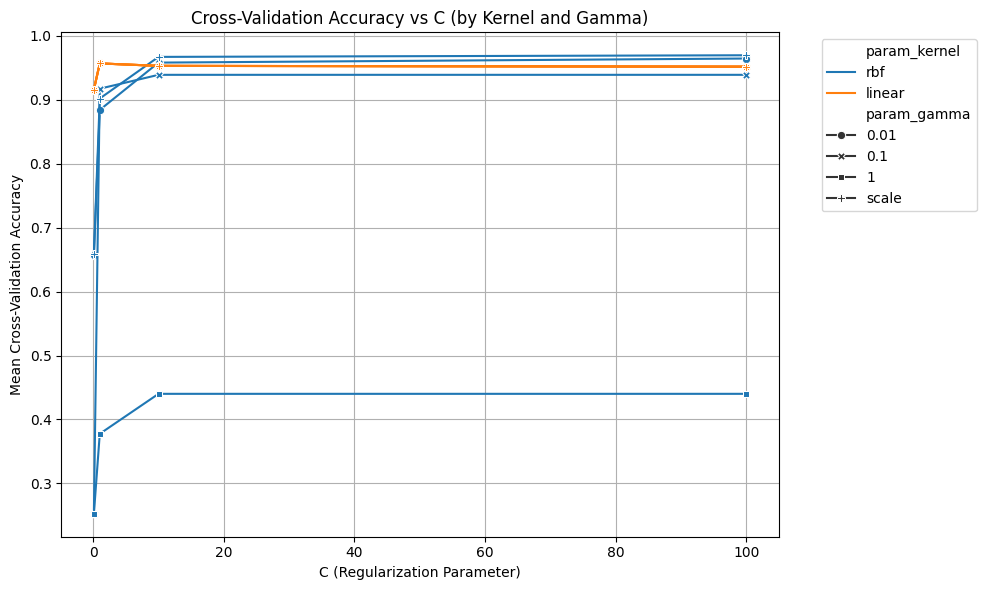

C:\Users\sahug\AppData\Local\Temp\ipykernel_20092\296680641.py:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


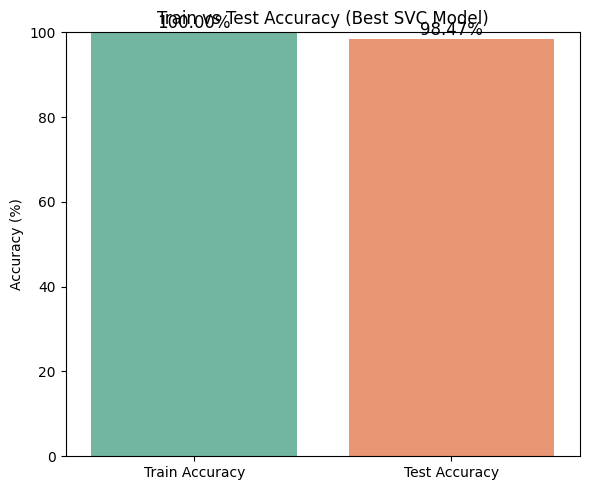

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

# --- 1. Load Data ---
file_path = 'processed_faces_newFinal8_1/facial_shapes_drawn_features_only.csv'
df = pd.read_csv(file_path)

# --- 2. Drop non-numeric column ---
df = df.drop(columns=['filename'])

# --- 3. Separate Features and Target ---
X = df.drop(columns=['emotion'])
y = df['emotion']

# --- 4. Encode Labels ---
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# --- 5. Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# --- 6. Scale Features ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 7. Define Parameter Grid for SVM ---
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.01, 0.1, 1, 'scale'],
    'kernel': ['rbf', 'linear']
}

# --- 8. Grid Search ---
print("Performing Grid Search...")
grid_search = GridSearchCV(
    SVC(), param_grid, cv=5, verbose=1, n_jobs=-1, return_train_score=True
)
grid_search.fit(X_train_scaled, y_train)

# --- 9. Best Model ---
best_svm = grid_search.best_estimator_
print("\n✅ Best Parameters:", grid_search.best_params_)

# --- 10. Evaluation ---
y_pred = best_svm.predict(X_test_scaled)

train_accuracy_tuned_svc = best_svm.score(X_train_scaled, y_train)
test_accuracy_tuned_svc = best_svm.score(X_test_scaled, y_test)

print(f"\n✅ Training Accuracy (Tuned SVC): {train_accuracy_tuned_svc * 100:.2f}%")
print(f"✅ Testing Accuracy  (Tuned SVC): {test_accuracy_tuned_svc * 100:.2f}%")

print("\n✅ Classification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))
print("\n✅ Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# --- 11. Accuracy Plot from Grid Search Results ---
results_df = pd.DataFrame(grid_search.cv_results_)

# Plot mean test accuracy
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=results_df,
    x='param_C', y='mean_test_score',
    hue='param_kernel', style='param_gamma', markers=True, dashes=False
)
plt.title('Cross-Validation Accuracy vs C (by Kernel and Gamma)')
plt.xlabel('C (Regularization Parameter)')
plt.ylabel('Mean Cross-Validation Accuracy')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 12. Bar Plot of Train vs Test Accuracy ---
plt.figure(figsize=(6, 5))
sns.barplot(
    x=['Train Accuracy', 'Test Accuracy'],
    y=[train_accuracy_tuned_svc * 100, test_accuracy_tuned_svc * 100],
    palette='Set2'
)
plt.title('Train vs Test Accuracy (Best SVC Model)')
plt.ylim(0, 100)
plt.ylabel('Accuracy (%)')
for index, value in enumerate([train_accuracy_tuned_svc * 100, test_accuracy_tuned_svc * 100]):
    plt.text(index, value + 1, f"{value:.2f}%", ha='center', fontsize=12)
plt.tight_layout()
plt.show()


Performing Grid Search...
Fitting 5 folds for each of 32 candidates, totalling 160 fits

✅ Best Parameters: {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}

✅ Training Accuracy (Tuned SVC): 100.00%
✅ Testing Accuracy  (Tuned SVC): 98.47%

✅ Classification Report:
               precision    recall  f1-score   support

       anger       1.00      1.00      1.00        27
    contempt       1.00      1.00      1.00        11
     disgust       1.00      0.91      0.96        35
        fear       1.00      1.00      1.00        15
       happy       0.93      1.00      0.96        41
     sadness       1.00      1.00      1.00        17
    surprise       1.00      1.00      1.00        50

    accuracy                           0.98       196
   macro avg       0.99      0.99      0.99       196
weighted avg       0.99      0.98      0.98       196


✅ Confusion Matrix:
 [[27  0  0  0  0  0  0]
 [ 0 11  0  0  0  0  0]
 [ 0  0 32  0  3  0  0]
 [ 0  0  0 15  0  0  0]
 [ 0  0  0  0 41  0  0

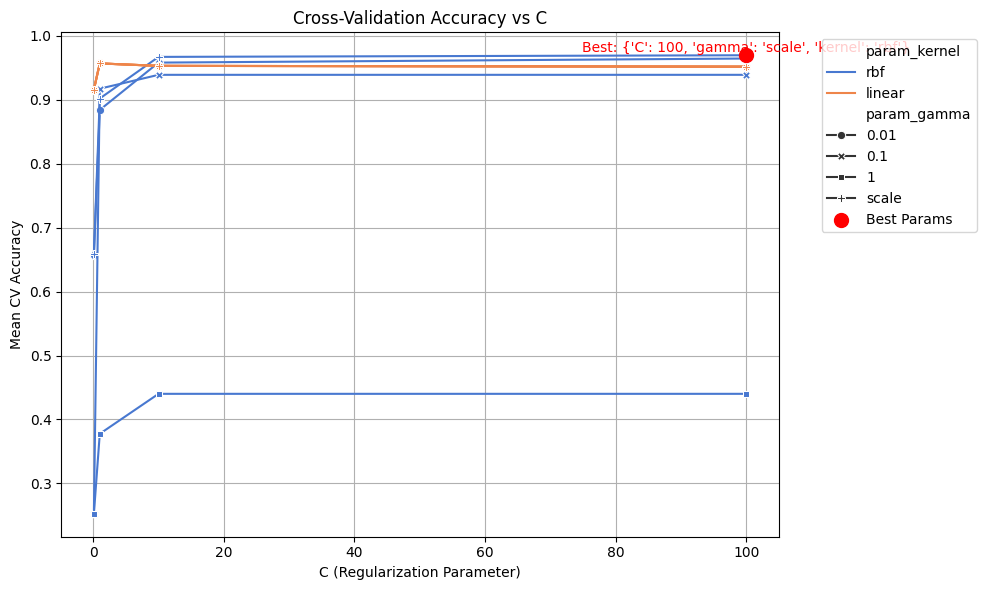

C:\Users\sahug\AppData\Local\Temp\ipykernel_20092\393619008.py:98: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


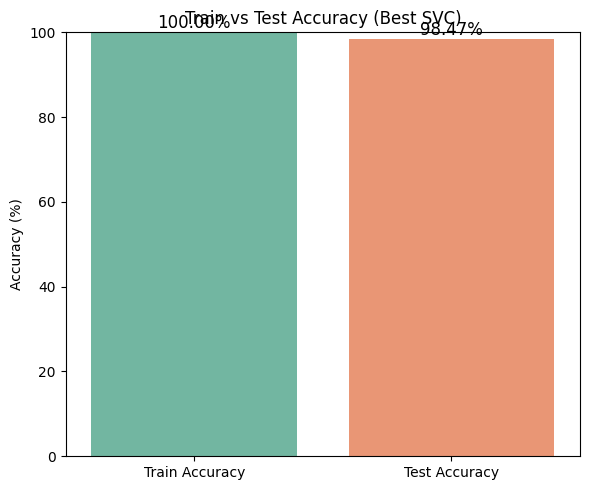

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

# --- 1. Load Data ---
file_path = 'processed_faces_newFinal8_1/facial_shapes_drawn_features_only.csv'
df = pd.read_csv(file_path)

# --- 2. Drop non-numeric column ---
df = df.drop(columns=['filename'])

# --- 3. Separate Features and Target ---
X = df.drop(columns=['emotion'])
y = df['emotion']

# --- 4. Encode Labels ---
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# --- 5. Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# --- 6. Scale Features ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 7. Define Parameter Grid for SVM ---
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.01, 0.1, 1, 'scale'],
    'kernel': ['rbf', 'linear']
}

# --- 8. Grid Search ---
print("Performing Grid Search...")
grid_search = GridSearchCV(
    SVC(), param_grid, cv=5, verbose=1, n_jobs=-1, return_train_score=True
)
grid_search.fit(X_train_scaled, y_train)

# --- 9. Best Model ---
best_svm = grid_search.best_estimator_
best_params = grid_search.best_params_
print("\n✅ Best Parameters:", best_params)

# --- 10. Evaluation ---
y_pred = best_svm.predict(X_test_scaled)

train_accuracy = best_svm.score(X_train_scaled, y_train)
test_accuracy = best_svm.score(X_test_scaled, y_test)

print(f"\n✅ Training Accuracy (Tuned SVC): {train_accuracy * 100:.2f}%")
print(f"✅ Testing Accuracy  (Tuned SVC): {test_accuracy * 100:.2f}%")

print("\n✅ Classification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))
print("\n✅ Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# --- 11. Accuracy Plot (highlight best param) ---
results_df = pd.DataFrame(grid_search.cv_results_)

plt.figure(figsize=(10, 6))
sns.lineplot(
    data=results_df,
    x='param_C', y='mean_test_score',
    hue='param_kernel', style='param_gamma',
    markers=True, dashes=False, palette='muted'
)

# Highlight the best score point
best_index = grid_search.best_index_
best_row = results_df.loc[best_index]
plt.scatter(
    best_row['param_C'], best_row['mean_test_score'],
    color='red', s=100, label='Best Params', zorder=10
)
plt.text(
    best_row['param_C'], best_row['mean_test_score'] + 0.005,
    f"Best: {best_params}", color='red', fontsize=10, ha='center'
)

plt.title('Cross-Validation Accuracy vs C')
plt.xlabel('C (Regularization Parameter)')
plt.ylabel('Mean CV Accuracy')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 12. Bar Plot: Train vs Test Accuracy ---
plt.figure(figsize=(6, 5))
sns.barplot(
    x=['Train Accuracy', 'Test Accuracy'],
    y=[train_accuracy * 100, test_accuracy * 100],
    palette='Set2'
)
plt.title('Train vs Test Accuracy (Best SVC)')
plt.ylim(0, 100)
plt.ylabel('Accuracy (%)')
for index, value in enumerate([train_accuracy * 100, test_accuracy * 100]):
    plt.text(index, value + 1, f"{value:.2f}%", ha='center', fontsize=12)
plt.tight_layout()
plt.show()


In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# --- 1. Load the CSV file ---
file_path = 'processed_faces_newFinal8_1/facial_shapes_drawn_features_only.csv'
df = pd.read_csv(file_path)

# --- 2. Drop non-numeric column ---
df = df.drop(columns=['filename'])

# --- 3. Separate features and target ---
X = df.drop(columns=['emotion'])
y = df['emotion']

# --- 4. Encode target labels ---
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# --- 5. Train-test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# --- 6. Scale features ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 7. Train Random Forest ---
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# --- 8. Predict and Evaluate ---
y_pred = rf_model.predict(X_test_scaled)

# print("✅ Training Accuracy (Random Forest):", round(rf_model.score(X_train_scaled, y_train), 2))
# print("✅ Testing Accuracy (Random Forest):", round(rf_model.score(X_test_scaled, y_test), 2))


train_accuracy_rf = rf_model.score(X_train_scaled, y_train)
test_accuracy_rf = rf_model.score(X_test_scaled, y_test)

print(f"✅ Training Accuracy (Random Forest): {train_accuracy_rf * 100:.2f}%")
print(f"✅ Testing Accuracy  (Random Forest): {test_accuracy_rf * 100:.2f}%")

print("\n✅ Classification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))
print("\n✅ Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


✅ Training Accuracy (Random Forest): 100.00%
✅ Testing Accuracy  (Random Forest): 95.92%

✅ Classification Report:
               precision    recall  f1-score   support

       anger       0.92      0.89      0.91        27
    contempt       1.00      1.00      1.00        11
     disgust       0.91      0.91      0.91        35
        fear       1.00      1.00      1.00        15
       happy       0.93      1.00      0.96        41
     sadness       1.00      0.88      0.94        17
    surprise       1.00      1.00      1.00        50

    accuracy                           0.96       196
   macro avg       0.97      0.96      0.96       196
weighted avg       0.96      0.96      0.96       196


✅ Confusion Matrix:
 [[24  0  3  0  0  0  0]
 [ 0 11  0  0  0  0  0]
 [ 0  0 32  0  3  0  0]
 [ 0  0  0 15  0  0  0]
 [ 0  0  0  0 41  0  0]
 [ 2  0  0  0  0 15  0]
 [ 0  0  0  0  0  0 50]]


In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# --- 1. Load the CSV file ---
file_path = 'processed_faces_newFinal8_1/facial_shapes_drawn_features_only.csv'
df = pd.read_csv(file_path)

# --- 2. Drop non-numeric/non-feature column ---
df = df.drop(columns=['filename'])

# --- 3. Separate features and target ---
X = df.drop(columns=['emotion'])
y = df['emotion']

# --- 4. Encode target labels ---
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# --- 5. Train-test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# --- 6. Feature Scaling ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 7. Train Logistic Regression model ---
log_model = LogisticRegression(max_iter=1000, random_state=42)
log_model.fit(X_train_scaled, y_train)

# --- 8. Predict and Evaluate ---
y_pred = log_model.predict(X_test_scaled)

# print("✅ Training Accuracy (Logistic Regression):", round(log_model.score(X_train_scaled, y_train), 2))
# print("✅ Testing Accuracy (Logistic Regression):", round(log_model.score(X_test_scaled, y_test), 2))


train_accuracy_logreg = log_model.score(X_train_scaled, y_train)
test_accuracy_logreg = log_model.score(X_test_scaled, y_test)

print(f"✅ Training Accuracy (Logistic Regression): {train_accuracy_logreg * 100:.2f}%")
print(f"✅ Testing Accuracy  (Logistic Regression): {test_accuracy_logreg * 100:.2f}%")

print("\n✅ Classification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))
print("\n✅ Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


✅ Training Accuracy (Logistic Regression): 97.96%
✅ Testing Accuracy  (Logistic Regression): 95.92%

✅ Classification Report:
               precision    recall  f1-score   support

       anger       0.86      0.93      0.89        27
    contempt       0.85      1.00      0.92        11
     disgust       0.97      0.97      0.97        35
        fear       1.00      1.00      1.00        15
       happy       1.00      1.00      1.00        41
     sadness       0.93      0.76      0.84        17
    surprise       1.00      0.98      0.99        50

    accuracy                           0.96       196
   macro avg       0.94      0.95      0.94       196
weighted avg       0.96      0.96      0.96       196


✅ Confusion Matrix:
 [[25  0  1  0  0  1  0]
 [ 0 11  0  0  0  0  0]
 [ 1  0 34  0  0  0  0]
 [ 0  0  0 15  0  0  0]
 [ 0  0  0  0 41  0  0]
 [ 3  1  0  0  0 13  0]
 [ 0  1  0  0  0  0 49]]


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix

# --- 1. Load the CSV file ---
file_path = 'processed_faces_newFinal8_1/facial_shapes_drawn_features_only.csv'
df = pd.read_csv(file_path)

# --- 2. Drop non-numeric/non-feature column ---
df = df.drop(columns=['filename'])

# --- 3. Separate features and target ---
X = df.drop(columns=['emotion'])
y = df['emotion']

# --- 4. Encode target labels ---
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# --- 5. Train-test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# --- 6. Feature Scaling ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 7. Train MLP Classifier ---
mlp_model = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)
mlp_model.fit(X_train_scaled, y_train)

# --- 8. Predict and Evaluate ---
y_pred = mlp_model.predict(X_test_scaled)

# print("✅ Training Accuracy (MLP):", round(mlp_model.score(X_train_scaled, y_train), 2))
# print("✅ Testing Accuracy (MLP):", round(mlp_model.score(X_test_scaled, y_test), 2))

train_accuracy_mlp = mlp_model.score(X_train_scaled, y_train)
test_accuracy_mlp = mlp_model.score(X_test_scaled, y_test)

print(f"✅ Training Accuracy (MLP): {train_accuracy_mlp * 100:.2f}%")
print(f"✅ Testing Accuracy  (MLP): {test_accuracy_mlp * 100:.2f}%")

print("\n✅ Classification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))
print("\n✅ Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


✅ Training Accuracy (MLP): 100.00%
✅ Testing Accuracy  (MLP): 97.96%

✅ Classification Report:
               precision    recall  f1-score   support

       anger       0.93      1.00      0.96        27
    contempt       1.00      1.00      1.00        11
     disgust       1.00      0.91      0.96        35
        fear       1.00      1.00      1.00        15
       happy       0.95      1.00      0.98        41
     sadness       1.00      0.94      0.97        17
    surprise       1.00      1.00      1.00        50

    accuracy                           0.98       196
   macro avg       0.98      0.98      0.98       196
weighted avg       0.98      0.98      0.98       196


✅ Confusion Matrix:
 [[27  0  0  0  0  0  0]
 [ 0 11  0  0  0  0  0]
 [ 1  0 32  0  2  0  0]
 [ 0  0  0 15  0  0  0]
 [ 0  0  0  0 41  0  0]
 [ 1  0  0  0  0 16  0]
 [ 0  0  0  0  0  0 50]]


c:\Users\sahug\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\sahug\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\sahug\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\sahug\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization has

Epoch 1/50 - Train Acc: 0.4247 | Test Acc: 0.4082 | Loss: 1.8955
Epoch 2/50 - Train Acc: 0.5855 | Test Acc: 0.5408 | Loss: 1.5848
Epoch 3/50 - Train Acc: 0.6314 | Test Acc: 0.6020 | Loss: 1.3567
Epoch 4/50 - Train Acc: 0.6773 | Test Acc: 0.6531 | Loss: 1.1808
Epoch 5/50 - Train Acc: 0.7168 | Test Acc: 0.6735 | Loss: 1.0342
Epoch 6/50 - Train Acc: 0.7309 | Test Acc: 0.6888 | Loss: 0.9071
Epoch 7/50 - Train Acc: 0.7628 | Test Acc: 0.7296 | Loss: 0.8002
Epoch 8/50 - Train Acc: 0.7972 | Test Acc: 0.7551 | Loss: 0.7112
Epoch 9/50 - Train Acc: 0.8265 | Test Acc: 0.7755 | Loss: 0.6362
Epoch 10/50 - Train Acc: 0.8571 | Test Acc: 0.7908 | Loss: 0.5726
Epoch 11/50 - Train Acc: 0.8648 | Test Acc: 0.8163 | Loss: 0.5184
Epoch 12/50 - Train Acc: 0.8763 | Test Acc: 0.8316 | Loss: 0.4727
Epoch 13/50 - Train Acc: 0.8852 | Test Acc: 0.8469 | Loss: 0.4327
Epoch 14/50 - Train Acc: 0.8941 | Test Acc: 0.8520 | Loss: 0.3990
Epoch 15/50 - Train Acc: 0.9094 | Test Acc: 0.8622 | Loss: 0.3687
Epoch 16/50 - Train

c:\Users\sahug\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\sahug\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\sahug\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\sahug\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization has

Epoch 27/50 - Train Acc: 0.9694 | Test Acc: 0.9490 | Loss: 0.1631
Epoch 28/50 - Train Acc: 0.9732 | Test Acc: 0.9490 | Loss: 0.1533
Epoch 29/50 - Train Acc: 0.9745 | Test Acc: 0.9490 | Loss: 0.1448
Epoch 30/50 - Train Acc: 0.9796 | Test Acc: 0.9490 | Loss: 0.1368
Epoch 31/50 - Train Acc: 0.9796 | Test Acc: 0.9541 | Loss: 0.1296
Epoch 32/50 - Train Acc: 0.9821 | Test Acc: 0.9592 | Loss: 0.1232
Epoch 33/50 - Train Acc: 0.9821 | Test Acc: 0.9541 | Loss: 0.1170
Epoch 34/50 - Train Acc: 0.9834 | Test Acc: 0.9592 | Loss: 0.1114
Epoch 35/50 - Train Acc: 0.9847 | Test Acc: 0.9592 | Loss: 0.1064
Epoch 36/50 - Train Acc: 0.9860 | Test Acc: 0.9643 | Loss: 0.1018
Epoch 37/50 - Train Acc: 0.9872 | Test Acc: 0.9592 | Loss: 0.0974
Epoch 38/50 - Train Acc: 0.9872 | Test Acc: 0.9643 | Loss: 0.0939
Epoch 39/50 - Train Acc: 0.9885 | Test Acc: 0.9643 | Loss: 0.0899


c:\Users\sahug\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\sahug\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\sahug\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\sahug\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization has

Epoch 40/50 - Train Acc: 0.9885 | Test Acc: 0.9643 | Loss: 0.0869
Epoch 41/50 - Train Acc: 0.9885 | Test Acc: 0.9643 | Loss: 0.0836
Epoch 42/50 - Train Acc: 0.9885 | Test Acc: 0.9643 | Loss: 0.0811
Epoch 43/50 - Train Acc: 0.9885 | Test Acc: 0.9643 | Loss: 0.0781
Epoch 44/50 - Train Acc: 0.9885 | Test Acc: 0.9643 | Loss: 0.0760
Epoch 45/50 - Train Acc: 0.9898 | Test Acc: 0.9643 | Loss: 0.0738
Epoch 46/50 - Train Acc: 0.9898 | Test Acc: 0.9643 | Loss: 0.0722
Epoch 47/50 - Train Acc: 0.9898 | Test Acc: 0.9643 | Loss: 0.0697
Epoch 48/50 - Train Acc: 0.9911 | Test Acc: 0.9643 | Loss: 0.0689
Epoch 49/50 - Train Acc: 0.9911 | Test Acc: 0.9643 | Loss: 0.0667
Epoch 50/50 - Train Acc: 0.9911 | Test Acc: 0.9694 | Loss: 0.0660

✅ Final Training Accuracy (MLP): 99.11%
✅ Final Testing Accuracy  (MLP): 96.94%

✅ Classification Report:
               precision    recall  f1-score   support

       anger       0.86      0.93      0.89        27
    contempt       1.00      0.91      0.95        11
   

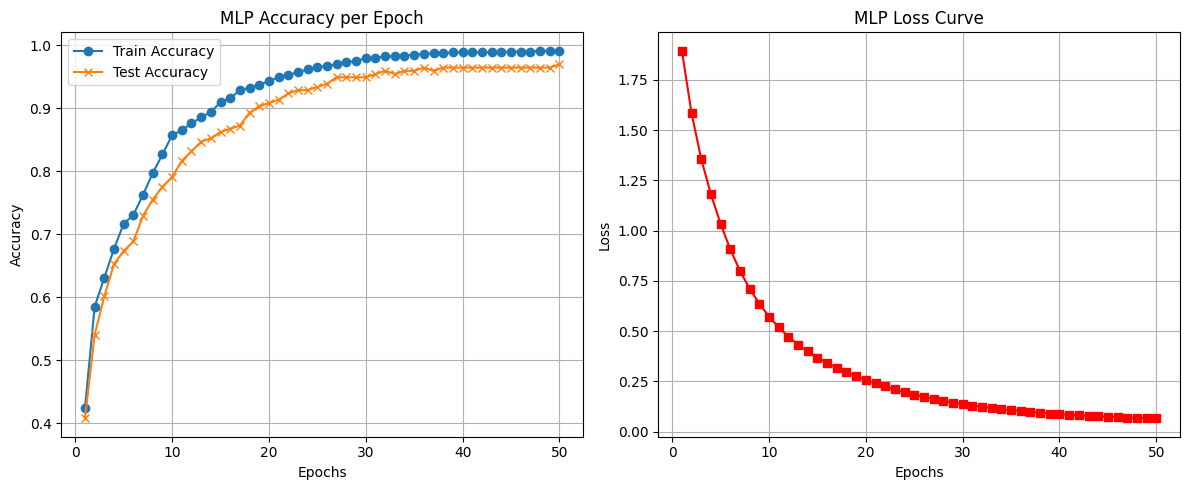

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# --- 1. Load the CSV file ---
file_path = 'processed_faces_newFinal8_1/facial_shapes_drawn_features_only.csv'
df = pd.read_csv(file_path)

# --- 2. Drop non-numeric/non-feature column ---
df = df.drop(columns=['filename'])

# --- 3. Separate features and target ---
X = df.drop(columns=['emotion'])
y = df['emotion']

# --- 4. Encode target labels ---
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# --- 5. Train-test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# --- 6. Feature Scaling ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 7. Train MLP Classifier with manual epoch tracking ---
epochs = 50
train_accuracies = []
test_accuracies = []

mlp_model = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1, warm_start=True, random_state=42, verbose=False)

for epoch in range(epochs):
    mlp_model.fit(X_train_scaled, y_train)

    train_acc = accuracy_score(y_train, mlp_model.predict(X_train_scaled))
    test_acc = accuracy_score(y_test, mlp_model.predict(X_test_scaled))

    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    print(f"Epoch {epoch+1}/{epochs} - Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f} | Loss: {mlp_model.loss_:.4f}")

# --- 8. Final Evaluation ---
y_pred = mlp_model.predict(X_test_scaled)

print(f"\n✅ Final Training Accuracy (MLP): {train_accuracies[-1] * 100:.2f}%")
print(f"✅ Final Testing Accuracy  (MLP): {test_accuracies[-1] * 100:.2f}%")

print("\n✅ Classification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))
print("\n✅ Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# --- 9. Plot Accuracy and Loss ---
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy', marker='o')
plt.plot(range(1, epochs + 1), test_accuracies, label='Test Accuracy', marker='x')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("MLP Accuracy per Epoch")
plt.legend()
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), mlp_model.loss_curve_, color='red', marker='s')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("MLP Loss Curve")
plt.grid(True)

plt.tight_layout()
plt.show()


Epoch 1/50
25/25 [==============================] - 1s 7ms/step - loss: 1.5391 - accuracy: 0.4094 - val_loss: 1.0780 - val_accuracy: 0.6224
Epoch 2/50
25/25 [==============================] - 0s 2ms/step - loss: 0.9017 - accuracy: 0.7130 - val_loss: 0.7696 - val_accuracy: 0.7398
Epoch 3/50
25/25 [==============================] - 0s 2ms/step - loss: 0.6346 - accuracy: 0.7959 - val_loss: 0.6129 - val_accuracy: 0.7959
Epoch 4/50
25/25 [==============================] - 0s 2ms/step - loss: 0.4848 - accuracy: 0.8520 - val_loss: 0.4985 - val_accuracy: 0.8316
Epoch 5/50
25/25 [==============================] - 0s 2ms/step - loss: 0.3799 - accuracy: 0.8852 - val_loss: 0.4253 - val_accuracy: 0.8776
Epoch 6/50
25/25 [==============================] - 0s 2ms/step - loss: 0.2983 - accuracy: 0.9184 - val_loss: 0.3707 - val_accuracy: 0.8980
Epoch 7/50
25/25 [==============================] - 0s 2ms/step - loss: 0.2481 - accuracy: 0.9413 - val_loss: 0.3202 - val_accuracy: 0.9337
Epoch 8/50
25/25 [==

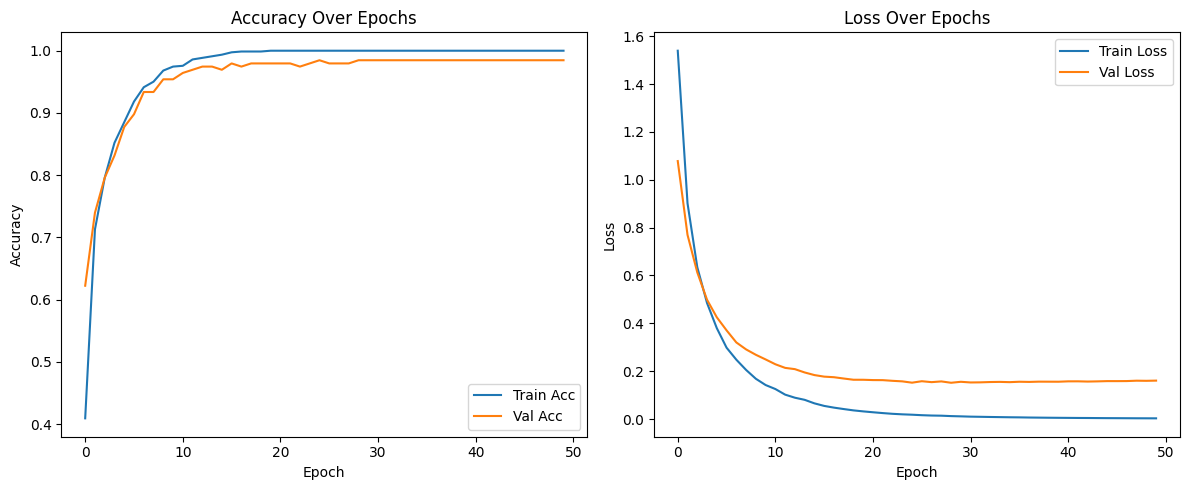

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

# --- 1. Load the CSV file ---
file_path = 'processed_faces_newFinal8_1/facial_shapes_drawn_features_only.csv'
df = pd.read_csv(file_path)

# --- 2. Drop non-numeric/non-feature column ---
df = df.drop(columns=['filename'])

# --- 3. Separate features and target ---
X = df.drop(columns=['emotion'])
y = df['emotion']

# --- 4. Encode target labels ---
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)  # For Keras model (one-hot)

# --- 5. Train-test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y_categorical, test_size=0.2, random_state=42, stratify=y_categorical
)

# --- 6. Feature Scaling ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 7. Build MLP model using Keras ---
model = Sequential([
    Dense(100, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(50, activation='relu'),
    Dense(y_categorical.shape[1], activation='softmax')  # Output layer
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# --- 8. Train the model ---
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=50,
    batch_size=32,
    verbose=1
)

# --- 9. Final Evaluation ---
train_loss, train_acc = model.evaluate(X_train_scaled, y_train, verbose=0)
test_loss, test_acc = model.evaluate(X_test_scaled, y_test, verbose=0)

print(f"\n✅ Final Training Accuracy (Keras MLP): {train_acc * 100:.2f}%")
print(f"✅ Final Testing Accuracy  (Keras MLP): {test_acc * 100:.2f}%")

# --- 10. Plot Accuracy & Loss Curves ---
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


Epoch 1/50
25/25 [==============================] - 1s 8ms/step - loss: 1.5632 - accuracy: 0.4439 - val_loss: 1.1218 - val_accuracy: 0.6429
Epoch 2/50
25/25 [==============================] - 0s 2ms/step - loss: 0.9287 - accuracy: 0.6913 - val_loss: 0.7933 - val_accuracy: 0.7602
Epoch 3/50
25/25 [==============================] - 0s 3ms/step - loss: 0.6588 - accuracy: 0.7844 - val_loss: 0.6164 - val_accuracy: 0.8367
Epoch 4/50
25/25 [==============================] - 0s 2ms/step - loss: 0.5045 - accuracy: 0.8648 - val_loss: 0.5093 - val_accuracy: 0.8571
Epoch 5/50
25/25 [==============================] - 0s 3ms/step - loss: 0.4030 - accuracy: 0.8852 - val_loss: 0.4470 - val_accuracy: 0.8673
Epoch 6/50
25/25 [==============================] - 0s 3ms/step - loss: 0.3320 - accuracy: 0.9158 - val_loss: 0.3895 - val_accuracy: 0.8878
Epoch 7/50
25/25 [==============================] - 0s 3ms/step - loss: 0.2699 - accuracy: 0.9260 - val_loss: 0.3447 - val_accuracy: 0.8980
Epoch 8/50
25/25 [==

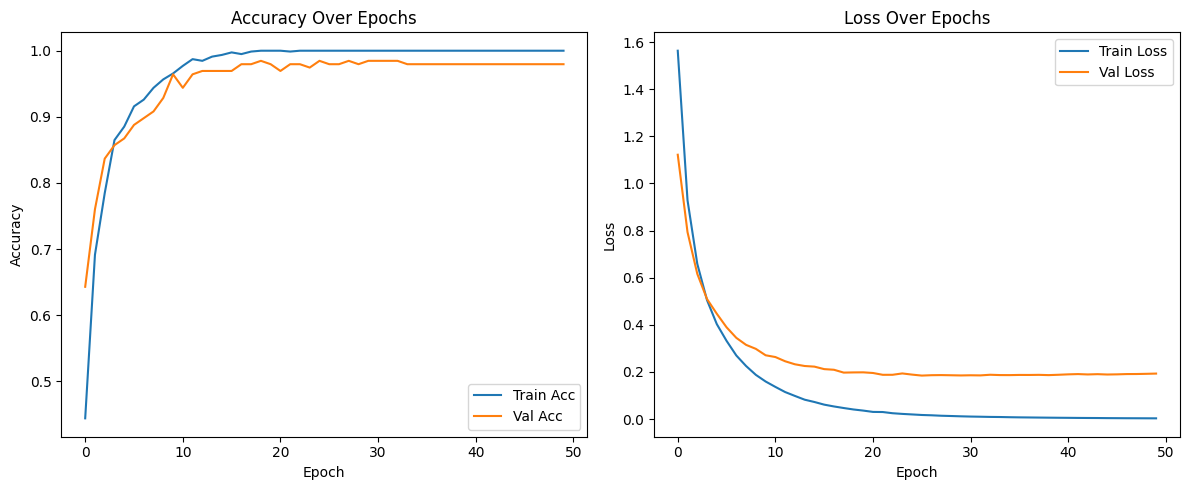

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix  # ✅ added here
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

# --- 1. Load the CSV file ---
file_path = 'processed_faces_newFinal8_1/facial_shapes_drawn_features_only.csv'
df = pd.read_csv(file_path)

# --- 2. Drop non-numeric/non-feature column ---
df = df.drop(columns=['filename'])

# --- 3. Separate features and target ---
X = df.drop(columns=['emotion'])
y = df['emotion']

# --- 4. Encode target labels ---
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)  # For Keras model (one-hot)

# --- 5. Train-test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y_categorical, test_size=0.2, random_state=42, stratify=y_categorical
)

# --- 6. Feature Scaling ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 7. Build MLP model using Keras ---
model = Sequential([
    Dense(100, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(50, activation='relu'),
    Dense(y_categorical.shape[1], activation='softmax')  # Output layer
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# --- 8. Train the model ---
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=50,
    batch_size=32,
    verbose=1
)

# --- 9. Final Evaluation ---
train_loss, train_acc = model.evaluate(X_train_scaled, y_train, verbose=0)
test_loss, test_acc = model.evaluate(X_test_scaled, y_test, verbose=0)

print(f"\n✅ Final Training Accuracy (Keras MLP): {train_acc * 100:.2f}%")
print(f"✅ Final Testing Accuracy  (Keras MLP): {test_acc * 100:.2f}%")

# --- ✅ Added: Classification Report & Confusion Matrix ---
y_test_labels = np.argmax(y_test, axis=1)
y_pred_labels = np.argmax(model.predict(X_test_scaled), axis=1)

print("\n✅ Classification Report:\n", classification_report(
    y_test_labels, y_pred_labels, target_names=label_encoder.classes_))

print("\n✅ Confusion Matrix:\n", confusion_matrix(y_test_labels, y_pred_labels))

# --- 10. Plot Accuracy & Loss Curves ---
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
